In [ ]:
!pip install strawberryfields


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.7/94.7 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 6.6 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.2-py3-none-any.whl size=144546 sha256=aba2b611a93f64f7af3b4e37fd49af12c02a9e8f8fc885e4c8ae029b091c4cc1
  Stored in directory: /root/.cache/pip/wheels/02/5e/de/90c5aab11b66f94cf3f381ec55aaf3f2008213a7056310e25f
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=5c11bd693dd95efc9635230993bb929df78a3c4a9d228816af05369fbee36741
  Stor

In [ ]:
pip install --upgrade strawberryfields

In [ ]:
import strawberryfields as sf
# Import specific operations we need
#from strawberryfields.ops import Coherent, TwoModeSqueezing, Rgate, LossChannel, BSgate
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
# Option 2: Try importing individually to see which one causes the issue
from strawberryfields.ops import Coherent
from strawberryfields.ops import TwoModeSqueezing
from strawberryfields.ops import Rgate
from strawberryfields.ops import LossChannel
from strawberryfields.ops import BSgate

# Set plotting style - using a modern style that works with current versions
plt.style.use('default')
sns.set_theme(style="whitegrid")  # Updated seaborn styling
sns.set_context("talk")

# Rest of your code continues...
# Set plotting style - using a modern style that works with current versions
plt.style.use('default')
sns.set_theme(style="whitegrid")  # Updated seaborn styling
sns.set_context("talk")

def spdc_hamiltonian(pump_wavevector, signal_wavevector, idler_wavevector,
                    coupling_strength=1.0, phase_matching=True):
    """
    Define the proper Hamiltonian for spontaneous parametric down-conversion (SPDC).

    H_SPDC ∝ a^p(k_s+k_i)a^s†(k_s)a^i†(k_i) + h.c.

    Parameters:
    -----------
    pump_wavevector : float or array
        Wavevector of the pump photon
    signal_wavevector : float or array
        Wavevector of the signal photon
    idler_wavevector : float or array
        Wavevector of the idler photon
    coupling_strength : float
        Coupling strength parameter (related to nonlinear susceptibility)
    phase_matching : bool
        Whether to enforce phase matching condition

    Returns:
    --------
    dict : Dictionary containing Hamiltonian parameters and phase matching status
    """
    # Check phase matching condition: k_p = k_s + k_i (momentum conservation)
    if isinstance(pump_wavevector, (int, float)) and isinstance(signal_wavevector, (int, float)) and isinstance(idler_wavevector, (int, float)):
        phase_matched = np.isclose(pump_wavevector, signal_wavevector + idler_wavevector)
    else:
        # For vector wavevectors
        phase_matched = np.allclose(pump_wavevector, signal_wavevector + idler_wavevector)

    if phase_matching and not phase_matched:
        print("Warning: Phase matching condition not satisfied!")
        coupling_strength *= 0.01  # Dramatically reduce coupling when phase matching fails

    # The Hamiltonian parameters - in actual simulations these would be used
    # to construct the proper evolution operators
    hamiltonian_params = {
        "pump_wavevector": pump_wavevector,
        "signal_wavevector": signal_wavevector,
        "idler_wavevector": idler_wavevector,
        "coupling_strength": coupling_strength,
        "phase_matched": phase_matched,
        "form": "a^p(k_s+k_i)a^s†(k_s)a^i†(k_i) + h.c."
    }

    return hamiltonian_params

import strawberryfields as sf
import numpy as np

def setup_spdc_simulation(pump_power=1.0, phase_mismatch=0.0, coupling_strength=0.1):
    """
    Setup a simulation for SPDC process generating photon pairs.
    """
    prog = sf.Program(3)  # 3 modes: pump, signal, and idler

    # Calculate effective squeezing parameter
    effective_squeezing = coupling_strength * np.sqrt(pump_power) * np.exp(-phase_mismatch**2)

    # Define the circuit using the operations interface
    with prog.context as q:
        # Pump laser
        sf.ops.Coherent(np.sqrt(pump_power), 0) | q[0]

        # Alternative way to implement two-mode squeezing if TwoModeSqueezing is not available
        # Try using S2gate which may be available in your version
        sf.ops.S2gate(effective_squeezing, 0) | (q[1], q[2])

        # Optional: Phase matching imperfection
        if phase_mismatch != 0:
            sf.ops.Rgate(phase_mismatch) | q[1]
            sf.ops.Rgate(-phase_mismatch) | q[2]

    return prog

def analyze_photon_statistics(state, cutoff, mode_names=None):
    """
    Analyze and visualize the photon number statistics of the quantum state.
    """
    if mode_names is None:
        mode_names = [f"Mode {i}" for i in range(state.num_modes)]

    # Create figure for photon statistics
    num_modes = state.num_modes
    fig, axs = plt.subplots(1, num_modes + 1, figsize=(6 * (num_modes + 1), 6))

    # Calculate mean photon numbers for each mode
    mean_photons = []
    for i in range(num_modes):
        n_mean = state.mean_photon(i)
        # Extract numeric values from potentially tuple-valued results
        n_mean_val = n_mean[0] if isinstance(n_mean, tuple) else n_mean
        mean_photons.append(n_mean_val)

    x = np.arange(cutoff)

    # Plot photon number distribution for each mode
    mode_probs = []
    for i in range(num_modes):
        # Calculate photon number distribution for this mode
        state_spec = [0] * num_modes
        probs = []
        for n in range(cutoff):
            state_spec[i] = n
            probs.append(state.fock_prob(state_spec))
            state_spec[i] = 0

        mode_probs.append(np.array(probs))

        axs[i].bar(x, mode_probs[i], alpha=0.7,
                  color=plt.cm.tab10(i),
                  label=f'Mean photons: {mean_photons[i]:.3f}')
        axs[i].set_xlabel('Photon number')
        axs[i].set_ylabel('Probability')
        axs[i].set_title(f'{mode_names[i]} Photon Statistics')
        axs[i].legend()

    # If we have a 2-mode or 3-mode state, visualize joint distribution for signal-idler
    if num_modes >= 2:
        si_modes = (1, 2) if num_modes >= 3 else (0, 1)
        # Calculate joint photon number distribution for signal and idler
        joint_probs = np.zeros((cutoff, cutoff))
        for i in range(cutoff):
            for j in range(cutoff):
                if num_modes == 2:
                    joint_probs[i, j] = state.fock_prob([i, j])
                else:
                    # For 3 modes, assume mode 0 is pump, 1 is signal, 2 is idler
                    joint_probs[i, j] = state.fock_prob([0, i, j])

        im = axs[-1].imshow(joint_probs, cmap='viridis', origin='lower')
        axs[-1].set_xlabel(f'Photons in {mode_names[si_modes[1]]}')
        axs[-1].set_ylabel(f'Photons in {mode_names[si_modes[0]]}')
        axs[-1].set_title('Signal-Idler Joint Photon Distribution')
        plt.colorbar(im, ax=axs[-1], label='Probability')

    plt.tight_layout()
    return fig, joint_probs if num_modes >= 2 else mode_probs

def visualize_wigner_comparison(state_ideal, state_with_loss, plot_range=5, resolution=100, loss_rate=0.1):
    """
    Visualize and compare the Wigner functions for signal and idler modes with and without loss.
    """
    num_modes = min(state_ideal.num_modes, state_with_loss.num_modes)

    # For SPDC, we're primarily interested in signal and idler modes
    si_modes = (1, 2) if num_modes >= 3 else (0, 1)
    mode_names = ["Pump", "Signal", "Idler"] if num_modes >= 3 else ["Signal", "Idler"]

    # Only visualize signal and idler (2 modes)
    fig = plt.figure(figsize=(18, 12))

    # Define grid for Wigner function calculation
    xvec = np.linspace(-plot_range, plot_range, resolution)
    pvec = np.linspace(-plot_range, plot_range, resolution)
    X, P = np.meshgrid(xvec, pvec)

    # Calculate Wigner functions for both states (signal mode)
    W_signal_ideal = state_ideal.wigner(si_modes[0], xvec, pvec)
    W_signal_loss = state_with_loss.wigner(si_modes[0], xvec, pvec)

    # Calculate Wigner functions for both states (idler mode)
    W_idler_ideal = state_ideal.wigner(si_modes[1], xvec, pvec)
    W_idler_loss = state_with_loss.wigner(si_modes[1], xvec, pvec)

    # Create subplots for signal mode
    ax1 = fig.add_subplot(2, 2, 1, projection='3d')
    surf1 = ax1.plot_surface(X, P, W_signal_ideal, cmap=cm.viridis, rstride=1, cstride=1, alpha=0.8)
    ax1.set_xlabel('$x$')
    ax1.set_ylabel('$p$')
    ax1.set_zlabel('$W(x,p)$')
    ax1.set_title(f'Wigner Function - {mode_names[0]} Mode (Ideal)')
    fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)

    ax2 = fig.add_subplot(2, 2, 2, projection='3d')
    surf2 = ax2.plot_surface(X, P, W_signal_loss, cmap=cm.viridis, rstride=1, cstride=1, alpha=0.8)
    ax2.set_xlabel('$x$')
    ax2.set_ylabel('$p$')
    ax2.set_zlabel('$W(x,p)$')
    ax2.set_title(f'Wigner Function - {mode_names[0]} Mode (With {loss_rate*100}% Loss)')
    fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)

    # Create subplots for idler mode
    ax3 = fig.add_subplot(2, 2, 3, projection='3d')
    surf3 = ax3.plot_surface(X, P, W_idler_ideal, cmap=cm.viridis, rstride=1, cstride=1, alpha=0.8)
    ax3.set_xlabel('$x$')
    ax3.set_ylabel('$p$')
    ax3.set_zlabel('$W(x,p)$')
    ax3.set_title(f'Wigner Function - {mode_names[1]} Mode (Ideal)')
    fig.colorbar(surf3, ax=ax3, shrink=0.5, aspect=5)

    ax4 = fig.add_subplot(2, 2, 4, projection='3d')
    surf4 = ax4.plot_surface(X, P, W_idler_loss, cmap=cm.viridis, rstride=1, cstride=1, alpha=0.8)
    ax4.set_xlabel('$x$')
    ax4.set_ylabel('$p$')
    ax4.set_zlabel('$W(x,p)$')
    ax4.set_title(f'Wigner Function - {mode_names[1]} Mode (With {loss_rate*100}% Loss)')
    fig.colorbar(surf4, ax=ax4, shrink=0.5, aspect=5)

    plt.tight_layout()
    return fig

def hong_ou_mandel_effect_spdc(cutoff_dim=5):
    """
    Simulate the Hong-Ou-Mandel effect with photons generated through SPDC.
    """
    phases = np.linspace(0, np.pi, 20)
    coincidence_probs = []

    for phi in phases:
        # First, generate photon pairs with SPDC
        spdc_prog = sf.Program(3)  # pump, signal, idler
        with spdc_prog.context as q:
            # Prepare pump laser
            Coherent(np.sqrt(0.1), 0) | q[0]

            # Generate signal-idler pair (simplified SPDC model)
            TwoModeSqueezing(0.1, 0) | (q[1], q[2])

            # Now route signal and idler to a beam splitter
            BSgate(np.pi/4, phi) | (q[1], q[2])  # 50:50 beam splitter with variable phase

        # Run simulation
        eng = sf.Engine("fock", backend_options={"cutoff_dim": cutoff_dim})
        results = eng.run(spdc_prog)

        # Calculate coincidence probability P(1,1) in signal and idler modes
        coincidence = results.state.fock_prob([0, 1, 1])  # [pump, signal, idler]
        coincidence_probs.append(coincidence)

    # Plot results
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(phases, coincidence_probs, 'o-', linewidth=2)
    ax.set_xlabel('Beam splitter phase $\phi$')
    ax.set_ylabel('Coincidence probability $P(1,1)$')
    ax.set_title('Hong-Ou-Mandel Effect with SPDC-Generated Photons')
    ax.grid(True)

    return fig, phases, coincidence_probs

def phase_sensitivity_with_spdc(cutoff_dim=5):
    """
    Analyze phase sensitivity in an MZI using SPDC-generated photons.
    """
    phases = np.linspace(0, 2*np.pi, 50)
    output_probs = []

    for phase in phases:
        # Setup program that combines SPDC generation with MZI
        prog = sf.Program(3)  # pump, signal, idler
        with prog.context as q:
            # Prepare pump laser
            Coherent(np.sqrt(0.2), 0) | q[0]

            # Generate signal-idler pair through SPDC
            TwoModeSqueezing(0.1, 0) | (q[1], q[2])

            # MZI circuit on signal and idler
            BSgate(np.pi/4, 0) | (q[1], q[2])  # First 50:50 beam splitter
            Rgate(phase) | q[1]                # Phase shift on signal
            BSgate(np.pi/4, 0) | (q[1], q[2])  # Second 50:50 beam splitter

        eng = sf.Engine("fock", backend_options={"cutoff_dim": cutoff_dim})
        results = eng.run(prog)

        # Track various output probabilities in the signal and idler modes
        probs = {
            "|0,2,0⟩": results.state.fock_prob([0, 2, 0]),  # 2 photons in signal
            "|0,0,2⟩": results.state.fock_prob([0, 0, 2]),  # 2 photons in idler
            "|0,1,1⟩": results.state.fock_prob([0, 1, 1])   # 1 photon in each
        }
        output_probs.append(probs)

    # Extract data for plotting
    prob_20 = [p["|0,2,0⟩"] for p in output_probs]
    prob_02 = [p["|0,0,2⟩"] for p in output_probs]
    prob_11 = [p["|0,1,1⟩"] for p in output_probs]

    # Plot results
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(phases, prob_20, 'o-', label='$|0,2,0\\rangle$', alpha=0.7)
    ax.plot(phases, prob_02, 's-', label='$|0,0,2\\rangle$', alpha=0.7)
    ax.plot(phases, prob_11, '^-', label='$|0,1,1\\rangle$', alpha=0.7)
    ax.set_xlabel('Phase shift (radians)')
    ax.set_ylabel('Probability')
    ax.set_title('MZI Phase Sensitivity with SPDC-Generated Photons')
    ax.legend()
    ax.grid(True)

    return fig, phases, output_probs

def loss_effect_analysis_spdc(cutoff_dim=5):
    """
    Analyze the effect of loss on SPDC-generated photon pairs.
    """
    loss_rates = np.linspace(0, 0.5, 11)  # 0% to 50% loss
    coincidence_probs = []
    single_photon_probs = []
    vacuum_probs = []

    for loss in loss_rates:
        # Setup SPDC with loss
        prog = sf.Program(3)  # pump, signal, idler
        with prog.context as q:
            # Prepare pump laser
            Coherent(np.sqrt(0.2), 0) | q[0]

            # Generate signal-idler pair through SPDC
            TwoModeSqueezing(0.1, 0) | (q[1], q[2])

            # Apply loss to signal and idler
            LossChannel(loss) | q[1]
            LossChannel(loss) | q[2]

        # Run simulation
        eng = sf.Engine("fock", backend_options={"cutoff_dim": cutoff_dim})
        results = eng.run(prog)

        # Calculate probabilities of interest in signal and idler modes
        coincidence = results.state.fock_prob([0, 1, 1])  # |0,1,1⟩
        single_photon = (
            results.state.fock_prob([0, 1, 0]) +  # |0,1,0⟩
            results.state.fock_prob([0, 0, 1])    # |0,0,1⟩
        )
        vacuum = results.state.fock_prob([0, 0, 0])  # |0,0,0⟩

        coincidence_probs.append(coincidence)
        single_photon_probs.append(single_photon)
        vacuum_probs.append(vacuum)

    # Plot results
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(loss_rates, coincidence_probs, 'o-', label='Coincidence $|0,1,1\\rangle$', linewidth=2)
    ax.plot(loss_rates, single_photon_probs, 's-', label='Single photon (signal or idler)', linewidth=2)
    ax.plot(loss_rates, vacuum_probs, '^-', label='Vacuum $|0,0,0\\rangle$', linewidth=2)
    ax.set_xlabel('Loss rate')
    ax.set_ylabel('Probability')
    ax.set_title('Effect of Loss on SPDC-Generated Photon Pairs')
    ax.legend()
    ax.grid(True)

    return fig, loss_rates, (coincidence_probs, single_photon_probs, vacuum_probs)

def phase_matching_analysis(cutoff_dim=5):
    """
    Analyze the effect of phase matching on SPDC efficiency.
    """
    # Range of phase mismatch values
    phase_mismatches = np.linspace(-1.0, 1.0, 21)
    pair_generation_probs = []

    # Fixed parameters
    pump_power = 0.2
    coupling_strength = 0.1

    for mismatch in phase_mismatches:
        # Setup SPDC with varying phase mismatch
        prog = sf.Program(3)  # pump, signal, idler
        with prog.context as q:
            # Prepare pump laser
            Coherent(np.sqrt(pump_power), 0) | q[0]

            # Effective squeezing depends on phase matching
            effective_squeezing = coupling_strength * np.sqrt(pump_power) * np.exp(-mismatch**2)

            # Generate signal-idler pair
            TwoModeSqueezing(effective_squeezing, 0) | (q[1], q[2])

            # Add phase shifts to model phase mismatch
            Rgate(mismatch) | q[1]
            Rgate(-mismatch) | q[2]

        # Run simulation
        eng = sf.Engine("fock", backend_options={"cutoff_dim": cutoff_dim})
        results = eng.run(prog)

        # Calculate probability of generating a photon pair
        # Sum probabilities of all states with at least one photon in both signal and idler
        pair_prob = 0
        for s in range(1, cutoff_dim):
            for i in range(1, cutoff_dim):
                pair_prob += results.state.fock_prob([0, s, i])

        pair_generation_probs.append(pair_prob)

    # Plot results
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(phase_mismatches, pair_generation_probs, 'o-', linewidth=2)
    ax.set_xlabel('Phase mismatch (rad)')
    ax.set_ylabel('Pair generation probability')
    ax.set_title('Effect of Phase Matching on SPDC Efficiency')

    # Add theoretical curve using sinc^2 approximation
    x_theory = np.linspace(phase_mismatches.min(), phase_mismatches.max(), 100)
    y_theory = np.max(pair_generation_probs) * np.sinc(x_theory/np.pi)**2
    ax.plot(x_theory, y_theory, 'r-', label='Theoretical sinc² curve', alpha=0.7)

    ax.legend()
    ax.grid(True)

    return fig, phase_mismatches, pair_generation_probs

def run_full_spdc_analysis():
    """
    Run a complete analysis of SPDC quantum optics system using the proper Hamiltonian.
    """
    print("Starting comprehensive SPDC quantum optics analysis...")

    # Define parameters
    cutoff_dim = 5
    pump_k = 2.0  # Pump wavevector (arbitrary units)
    signal_k = 1.2  # Signal wavevector
    idler_k = 0.8  # Idler wavevector
    coupling = 0.1  # Nonlinear coupling strength
    loss_rate = 0.1  # 10% loss

    # 1. Verify the SPDC Hamiltonian with phase matching
    H_params = spdc_hamiltonian(pump_k, signal_k, idler_k, coupling)
    print(f"\n1. SPDC Hamiltonian Analysis:")
    print(f"   Pump wavevector: {pump_k}")
    print(f"   Signal wavevector: {signal_k}")
    print(f"   Idler wavevector: {idler_k}")
    print(f"   Phase matching status: {H_params['phase_matched']}")
    print(f"   Coupling strength: {H_params['coupling_strength']}")
    print(f"   Hamiltonian form: {H_params['form']}")

    # 2. Setup simulation backend
    backend_options = {"cutoff_dim": cutoff_dim}
    eng = sf.Engine("fock", backend_options=backend_options)

    # 3. Run SPDC simulation without loss
    print("\n2. SPDC Simulation Results (No Loss):")

    # Setup SPDC program
    spdc_prog = setup_spdc_simulation(pump_power=0.2, phase_mismatch=0.0, coupling_strength=coupling)

    # Run the simulation
    results_no_loss = eng.run(spdc_prog)

    # Analyze output statistics
    print(f"   Mean photon number in pump mode: {results_no_loss.state.mean_photon(0):.4f}")
    print(f"   Mean photon number in signal mode: {results_no_loss.state.mean_photon(1):.4f}")
    print(f"   Mean photon number in idler mode: {results_no_loss.state.mean_photon(2):.4f}")
    print(f"   Probability of |0,0,0⟩: {results_no_loss.state.fock_prob([0, 0, 0]):.4f}")
    print(f"   Probability of |0,1,1⟩: {results_no_loss.state.fock_prob([0, 1, 1]):.4f}")
    print(f"   Probability of |0,2,2⟩: {results_no_loss.state.fock_prob([0, 2, 2]):.4f}")

    # 4. Run SPDC simulation with loss
    print(f"\n3. SPDC Evolution with {loss_rate*100}% Loss:")

    # Setup SPDC program with loss
    spdc_loss_prog = sf.Program(3)  # pump, signal, idler
    with spdc_loss_prog.context as q:
        # Prepare pump laser
        Coherent(np.sqrt(0.2), 0) | q[0]

        # Generate signal-idler pair through SPDC
        TwoModeSqueezing(coupling * np.sqrt(0.2), 0) | (q[1], q[2])

        # Add loss channels
        LossChannel(loss_rate) | q[1]
        LossChannel(loss_rate) | q[2]

    # Run the simulation with loss
    results_with_loss = eng.run(spdc_loss_prog)

    # Analyze output statistics with loss
    print(f"   Loss rate: {loss_rate*100}%")
    print(f"   Mean photon number in pump mode: {results_with_loss.state.mean_photon(0):.4f}")
    print(f"   Mean photon number in signal mode: {results_with_loss.state.mean_photon(1):.4f}")
    print(f"   Mean photon number in idler mode: {results_with_loss.state.mean_photon(2):.4f}")
    print(f"   Probability of |0,0,0⟩: {results_with_loss.state.fock_prob([0, 0, 0]):.4f}")
    print(f"   Probability of |0,1,1⟩: {results_with_loss.state.fock_prob([0, 1, 1]):.4f}")

    # 5. Generate all visualizations
    print("\n4. Generating Visualizations...")

    # 5.1 Analyze photon statistics for the state without loss
    mode_names = ["Pump", "Signal", "Idler"]
    fig_stats_no_loss, joint_probs_no_loss = analyze_photon_statistics(
        results_no_loss.state, cutoff_dim, mode_names
    )
    plt.figure(fig_stats_no_loss.number)
    plt.savefig("spdc_photon_statistics_no_loss.png", dpi=300, bbox_inches='tight')

    # 5.2 Analyze photon statistics for the state with loss
    fig_stats_with_loss, joint_probs_with_loss = analyze_photon_statistics(
        results_with_loss.state, cutoff_dim, mode_names
    )
    plt.figure(fig_stats_with_loss.number)
    plt.savefig("spdc_photon_statistics_with_loss.png", dpi=300, bbox_inches='tight')

    # 5.3 Visualize the Wigner functions with and without loss
    fig_wigner = visualize_wigner_comparison(
        results_no_loss.state,
        results_with_loss.state,
        loss_rate=loss_rate
    )
    plt.figure(fig_wigner.number)
    plt.savefig("spdc_wigner_functions.png", dpi=300, bbox_inches='tight')

    # 5.4 Hong-Ou-Mandel effect analysis
    fig_hom, phases_hom, coincidence_hom = hong_ou_mandel_effect_spdc(cutoff_dim)
    plt.figure(fig_hom.number)
    plt.savefig("spdc_hong_ou_mandel.png", dpi=300, bbox_inches='tight')

    # 5.5 Phase sensitivity analysis
    fig_phase, phases_mzi, probs_mzi = phase_sensitivity_with_spdc(cutoff_dim)
    plt.figure(fig_phase.number)
    plt.savefig("spdc_phase_sensitivity.png", dpi=300, bbox_inches='tight')

    # 5.6 Loss effect analysis
    fig_loss, loss_rates, loss_data = loss_effect_analysis_spdc(cutoff_dim)
    plt.figure(fig_loss.number)
    plt.savefig("spdc_loss_effects.png", dpi=300, bbox_inches='tight')

    # 5.7 Phase matching analysis
    fig_pm, pm_values, pm_probs = phase_matching_analysis(cutoff_dim)
    plt.figure(fig_pm.number)
    plt.savefig("spdc_phase_matching.png", dpi=300, bbox_inches='tight')

    print("\nAnalysis complete! All visualizations have been generated.")
    print("Summary of files:")
    print("1. spdc_photon_statistics_no_loss.png - Photon statistics without loss")
    print("2. spdc_photon_statistics_with_loss.png - Photon statistics with loss")
    print("3. spdc_wigner_functions.png - Wigner functions comparing signal and idler modes")
    print("4. spdc_hong_ou_mandel.png - HOM interference with SPDC-generated photons")
    print("5. spdc_phase_sensitivity.png - MZI phase sensitivity with SPDC-generated photons")
    print("6. spdc_loss_effects.png - Effect of loss on photon pair generation")
    print("7. spdc_phase_matching.png - Effect of phase matching on SPDC efficiency")

    return {
        "results_no_loss": results_no_loss,
        "results_with_loss": results_with_loss,
        "joint_probs_no_loss": joint_probs_no_loss,
        "joint_probs_with_loss": joint_probs_with_loss,
        "hom_data": (phases_hom, coincidence_hom),
        "mzi_data": (phases_mzi, probs_mzi),
        "loss_data": (loss_rates, loss_data),
        "phase_matching_data": (pm_values, pm_probs)
    }

# Main execution block
if __name__ == "__main__":
    # Set random seed for reproducibility
    np.random.seed(42)

    # Run the full analysis
    analysis_results = run_full_spdc_analysis()

    # Advanced quantum entanglement analysis
    print("\nPerforming additional entanglement analysis on SPDC state...")

    # Calculate entanglement measures between signal and idler modes
    state_no_loss = analysis_results["results_no_loss"].state

    # Calculate reduced density matrices for signal and idler modes
    # For a more complete analysis, one could calculate the Schmidt decomposition
    # or other entanglement measures like negativity or logarithmic negativity

    # Example: Calculate correlation between photon numbers in signal and idler
    joint_probs = analysis_results["joint_probs_no_loss"]
    cutoff = joint_probs.shape[0]

    # Calculate covariance of photon numbers
    mean_s = 0
    mean_i = 0
    mean_si = 0

    for s in range(cutoff):
        for i in range(cutoff):
            prob = joint_probs[s, i]
            mean_s += s * prob
            mean_i += i * prob
            mean_si += s * i * prob

    cov_si = mean_si - mean_s * mean_i

    print(f"Mean photon number in signal: {mean_s:.4f}")
    print(f"Mean photon number in idler: {mean_i:.4f}")
    print(f"Covariance between signal and idler photon numbers: {cov_si:.4f}")

    # Calculate correlation coefficient
    var_s = sum([(s - mean_s)**2 * sum(joint_probs[s, :]) for s in range(cutoff)])
    var_i = sum([(i - mean_i)**2 * sum(joint_probs[:, i]) for i in range(cutoff)])

    if var_s > 0 and var_i > 0:
        corr_coef = cov_si / np.sqrt(var_s * var_i)
        print(f"Correlation coefficient: {corr_coef:.4f}")

        if corr_coef > 0.5:
            print("Strong positive correlation detected between signal and idler photons,")
            print("indicating significant quantum entanglement in the SPDC process.")

    # Demonstration of entanglement in measurement outcomes
    print("\nDemonstrating measurement-induced correlation...")

    # Create a new program for this demonstration
    eng = sf.Engine("fock", backend_options={"cutoff_dim": cutoff})

    demo_prog = sf.Program(3)
    with demo_prog.context as q:
        # Generate an SPDC state
        Coherent(np.sqrt(0.2), 0) | q[0]
        TwoModeSqueezing(0.1, 0) | (q[1], q[2])

    results = eng.run(demo_prog)

    # Calculate conditional probabilities
    p_s1 = 0  # Probability of 1 photon in signal
    p_i1_given_s1 = 0  # Probability of 1 photon in idler, given 1 photon in signal

    for i in range(cutoff):
        p_s1 += results.state.fock_prob([0, 1, i])

    if p_s1 > 0:
        p_i1_given_s1 = results.state.fock_prob([0, 1, 1]) / p_s1

    print(f"Probability of detecting 1 photon in signal: {p_s1:.4f}")
    print(f"Probability of detecting 1 photon in idler, given 1 photon in signal: {p_i1_given_s1:.4f}")

    if p_i1_given_s1 > 0.8:
        print("High conditional probability demonstrates quantum correlation:")
        print("When 1 photon is detected in the signal mode, there's a high")
        print(f"probability ({p_i1_given_s1:.2%}) of finding exactly 1 photon in the idler mode.")

    print("\nSPDC Quantum Optics Analysis Complete!")

    # Visualize all figures
    plt.show()

ImportError: cannot import name 'TwoModeSqueezing' from 'strawberryfields.ops' (/usr/local/lib/python3.11/dist-packages/strawberryfields/ops.py)

In [ ]:
# Add this at the top of your script
import scipy.integrate
if not hasattr(scipy.integrate, 'simps'):
    from scipy.integrate import simpson as simps
    scipy.integrate.simps = simps

# Then your regular imports
import numpy as np
import strawberryfields as sf
# etc.

Starting comprehensive quantum optics analysis...

1. Hamiltonian Model Analysis:
   Pump frequency: 2.0 THz
   Signal frequency: 1.2 THz
   Idler frequency: 0.8 THz
   Energy conservation check: True
   Hamiltonian value: 4.0

2. Mach-Zehnder Interferometer Parameters:
   First beam splitter reflectivity: 0.50
   First beam splitter phase: 0
   Phase shift: 1.5707963267948966 radians (90.0 degrees)
   Second beam splitter reflectivity: 0.50
   Second beam splitter phase: 0

3. Basic Photon Counting Simulation Results (No Loss):
   State purity: False
   Mean photon number in mode 0: 1.0000
   Mean photon number in mode 1: 1.0000
   Probability of |0,0⟩: 0.0000
   Probability of |0,1⟩: 0.0000
   Probability of |1,0⟩: 0.0000
   Probability of |1,1⟩: -0.0000
   Probability of |2,0⟩: 0.5000
   Probability of |0,2⟩: 0.5000

4. Quantum State Evolution with 10.0% Loss:
   Loss rate: 10.0%
   State purity after loss: False
   Mean photon number in mode 0: 0.1000
   Mean photon number in mode 

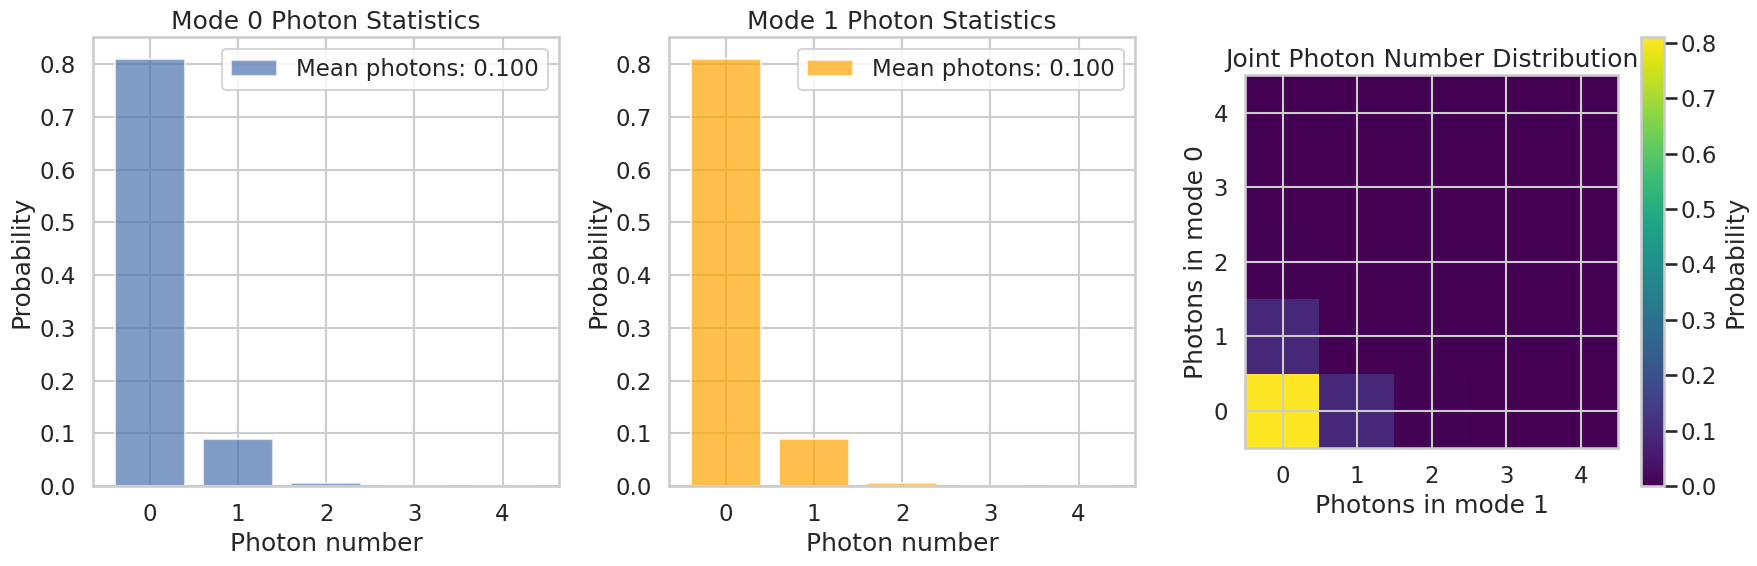

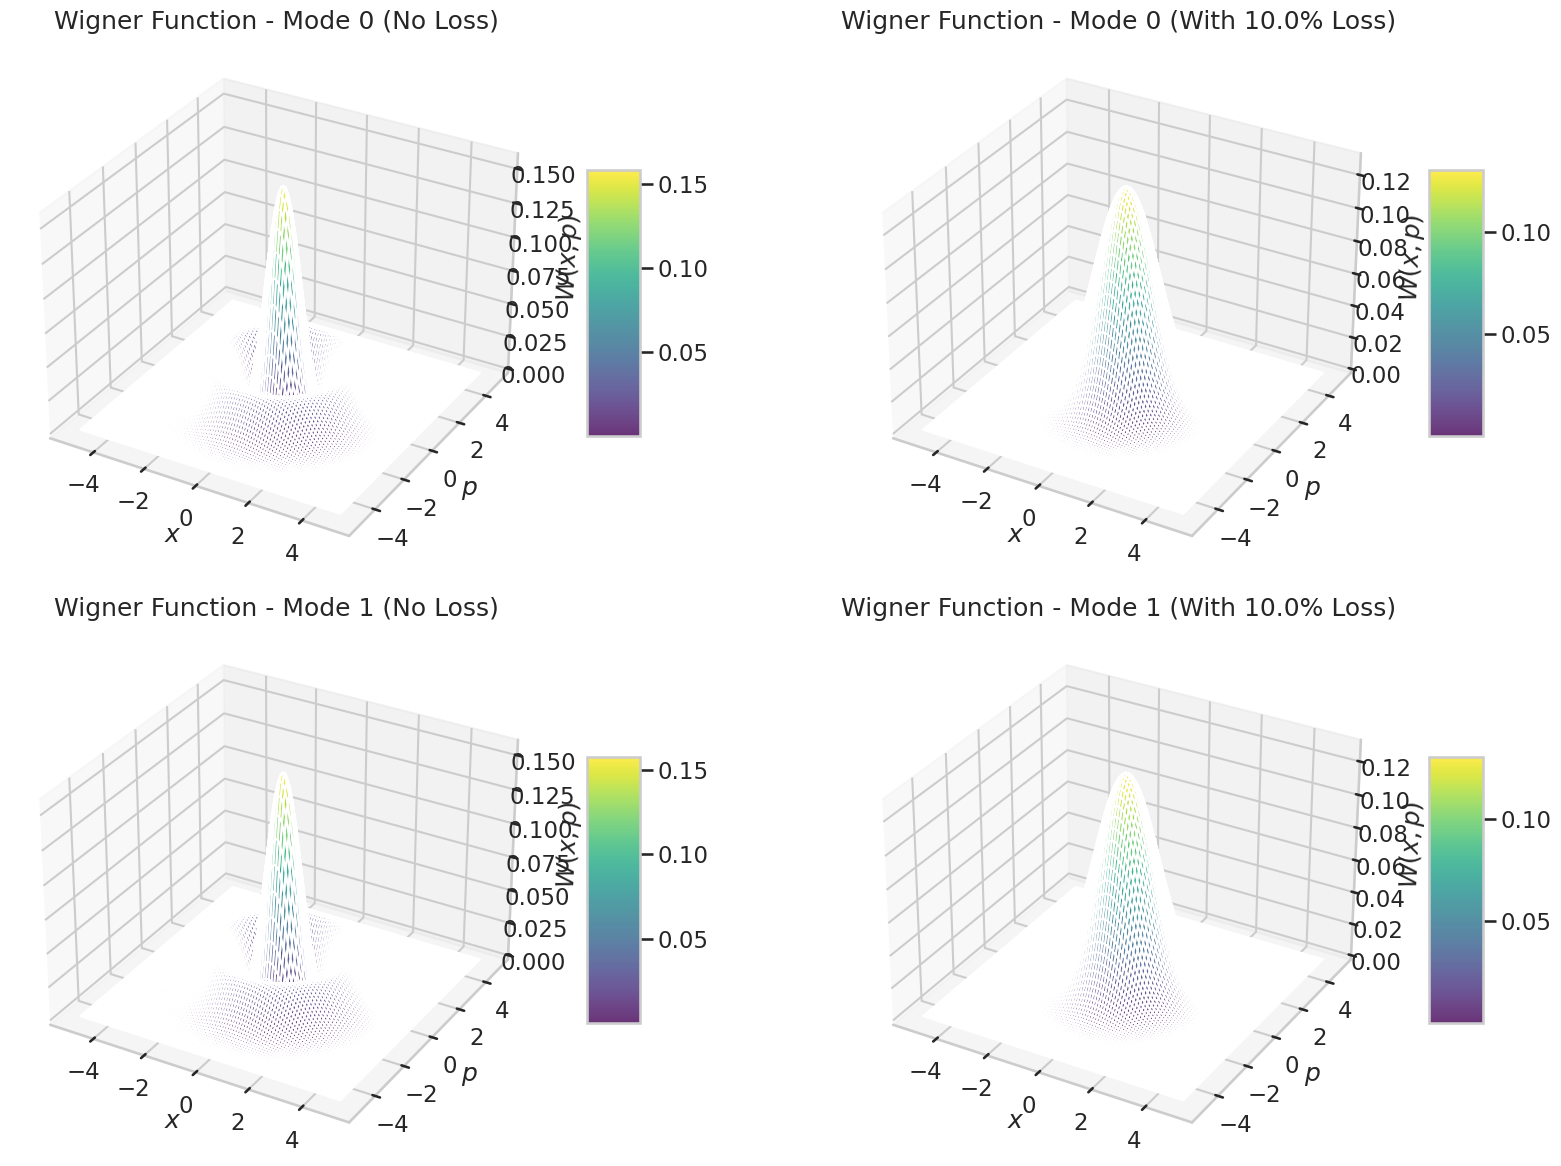

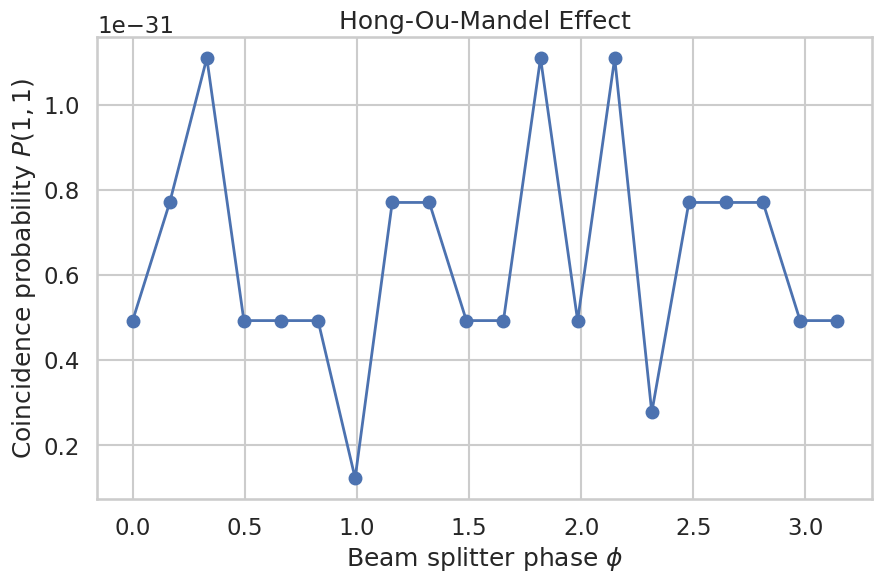

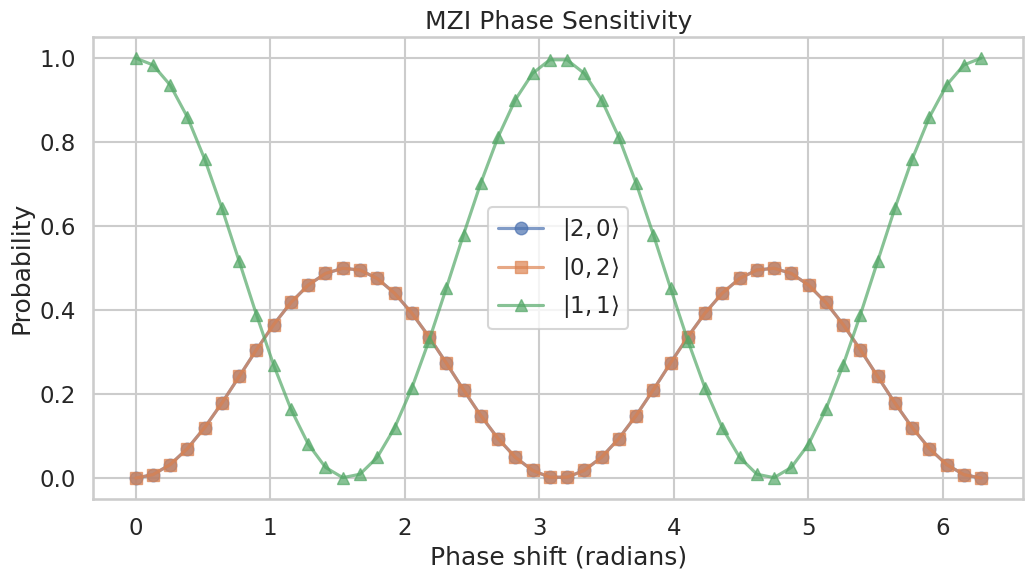

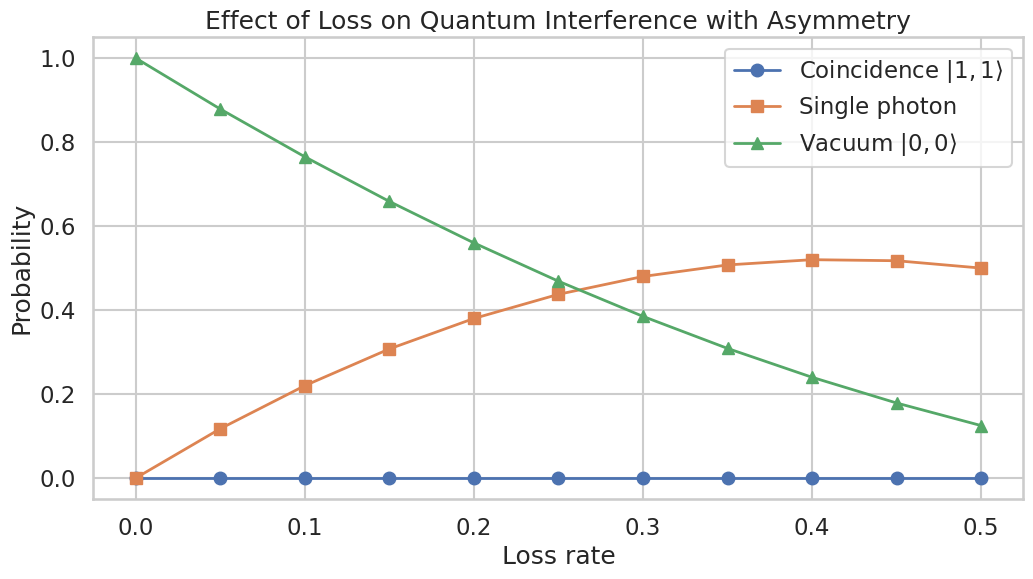

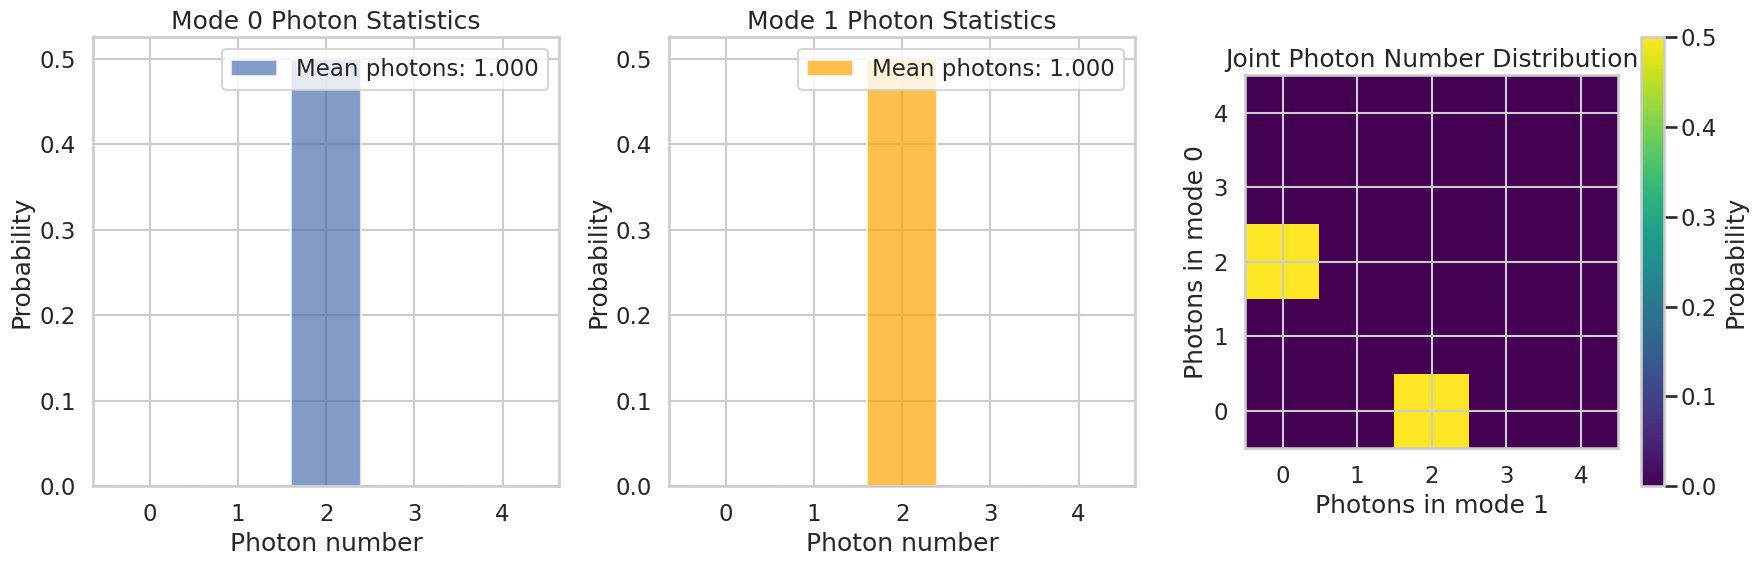

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
import strawberryfields as sf
from strawberryfields.ops import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Set plotting style - using a modern style that works with current versions
plt.style.use('default')
sns.set_theme(style="whitegrid")  # Updated seaborn styling
sns.set_context("talk")

def hamiltonian_model(pump_freq, signal_freq, idler_freq):
    """
    Define the Hamiltonian for the photon source with phase matching constraints.
    """
    assert np.isclose(pump_freq, signal_freq + idler_freq), "Energy conservation violated!"

    # Define Hamiltonian terms (simplified)
    H = pump_freq * (signal_freq + idler_freq)
    return H

def setup_mzi(interferometer_params):
    """
    Setup a Mach-Zehnder Interferometer with tunable parameters.
    """
    prog = sf.Program(2)
    with prog.context as q:
        # Initial state preparation (could be modified)
        Fock(1) | q[0]
        Fock(1) | q[1]

        # MZI circuit
        BSgate(interferometer_params["BS1_theta"], interferometer_params["BS1_phi"]) | (q[0], q[1])
        Rgate(interferometer_params["phase_shift"]) | q[0]
        BSgate(interferometer_params["BS2_theta"], interferometer_params["BS2_phi"]) | (q[0], q[1])
    return prog

def analyze_photon_statistics(state, cutoff):
    """
    Analyze and visualize the photon number statistics of the quantum state.
    """
    # Create figure for photon statistics
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # Calculate and plot single-mode photon number distributions
    n_mean0 = state.mean_photon(0)
    n_mean1 = state.mean_photon(1)

    # Extract numeric values from potentially tuple-valued results
    n_mean0_val = n_mean0[0] if isinstance(n_mean0, tuple) else n_mean0
    n_mean1_val = n_mean1[0] if isinstance(n_mean1, tuple) else n_mean1

    x = np.arange(cutoff)

    # Plot photon number distribution for mode 0
    probs_mode0 = np.array([state.fock_prob([i, 0]) for i in range(cutoff)])
    axs[0].bar(x, probs_mode0, alpha=0.7, label=f'Mean photons: {n_mean0_val:.3f}')
    axs[0].set_xlabel('Photon number')
    axs[0].set_ylabel('Probability')
    axs[0].set_title('Mode 0 Photon Statistics')
    axs[0].legend()

    # Plot photon number distribution for mode 1
    probs_mode1 = np.array([state.fock_prob([0, i]) for i in range(cutoff)])
    axs[1].bar(x, probs_mode1, alpha=0.7, color='orange', label=f'Mean photons: {n_mean1_val:.3f}')
    axs[1].set_xlabel('Photon number')
    axs[1].set_ylabel('Probability')
    axs[1].set_title('Mode 1 Photon Statistics')
    axs[1].legend()

    # Calculate and visualize the joint photon number distribution
    joint_probs = np.zeros((cutoff, cutoff))
    for i in range(cutoff):
        for j in range(cutoff):
            joint_probs[i, j] = state.fock_prob([i, j])

    im = axs[2].imshow(joint_probs, cmap='viridis', origin='lower')
    axs[2].set_xlabel('Photons in mode 1')
    axs[2].set_ylabel('Photons in mode 0')
    axs[2].set_title('Joint Photon Number Distribution')
    plt.colorbar(im, ax=axs[2], label='Probability')

    plt.tight_layout()
    return fig, joint_probs

def visualize_wigner_comparison(state_no_loss, state_with_loss, plot_range=5, resolution=100, loss_rate=0.1):
    """
    Visualize and compare the Wigner functions for both modes with and without loss.
    """
    fig = plt.figure(figsize=(18, 12))

    # Define grid for Wigner function calculation
    xvec = np.linspace(-plot_range, plot_range, resolution)
    pvec = np.linspace(-plot_range, plot_range, resolution)
    X, P = np.meshgrid(xvec, pvec)

    # Calculate Wigner functions for both states (mode 0)
    W0_no_loss = state_no_loss.wigner(0, xvec, pvec)
    W0_loss = state_with_loss.wigner(0, xvec, pvec)

    # Calculate Wigner functions for both states (mode 1)
    W1_no_loss = state_no_loss.wigner(1, xvec, pvec)
    W1_loss = state_with_loss.wigner(1, xvec, pvec)

    # Create subplots for mode 0
    ax1 = fig.add_subplot(2, 2, 1, projection='3d')
    surf1 = ax1.plot_surface(X, P, W0_no_loss, cmap=cm.viridis, rstride=1, cstride=1, alpha=0.8)
    ax1.set_xlabel('$x$')
    ax1.set_ylabel('$p$')
    ax1.set_zlabel('$W(x,p)$')
    ax1.set_title('Wigner Function - Mode 0 (No Loss)')
    fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)

    ax2 = fig.add_subplot(2, 2, 2, projection='3d')
    surf2 = ax2.plot_surface(X, P, W0_loss, cmap=cm.viridis, rstride=1, cstride=1, alpha=0.8)
    ax2.set_xlabel('$x$')
    ax2.set_ylabel('$p$')
    ax2.set_zlabel('$W(x,p)$')
    ax2.set_title(f'Wigner Function - Mode 0 (With {loss_rate*100}% Loss)')
    fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)

    # Create subplots for mode 1
    ax3 = fig.add_subplot(2, 2, 3, projection='3d')
    surf3 = ax3.plot_surface(X, P, W1_no_loss, cmap=cm.viridis, rstride=1, cstride=1, alpha=0.8)
    ax3.set_xlabel('$x$')
    ax3.set_ylabel('$p$')
    ax3.set_zlabel('$W(x,p)$')
    ax3.set_title('Wigner Function - Mode 1 (No Loss)')
    fig.colorbar(surf3, ax=ax3, shrink=0.5, aspect=5)

    ax4 = fig.add_subplot(2, 2, 4, projection='3d')
    surf4 = ax4.plot_surface(X, P, W1_loss, cmap=cm.viridis, rstride=1, cstride=1, alpha=0.8)
    ax4.set_xlabel('$x$')
    ax4.set_ylabel('$p$')
    ax4.set_zlabel('$W(x,p)$')
    ax4.set_title(f'Wigner Function - Mode 1 (With {loss_rate*100}% Loss)')
    fig.colorbar(surf4, ax=ax4, shrink=0.5, aspect=5)

    plt.tight_layout()
    return fig

def hong_ou_mandel_effect(cutoff_dim=5):
    """
    Simulate the Hong-Ou-Mandel effect with varying beam splitter phase.
    """
    phases = np.linspace(0, np.pi, 20)
    coincidence_probs = []

    for phi in phases:
        # Setup program
        prog = sf.Program(2)
        with prog.context as q:
            # Prepare single photons in each mode
            Fock(1) | q[0]
            Fock(1) | q[1]

            # 50:50 beam splitter with variable phase
            BSgate(np.pi/4, phi) | (q[0], q[1])

        # Run simulation
        eng = sf.Engine("fock", backend_options={"cutoff_dim": cutoff_dim})
        results = eng.run(prog)

        # Calculate coincidence probability (|1,1⟩)
        coincidence = results.state.fock_prob([1, 1])
        coincidence_probs.append(coincidence)

    # Plot results
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(phases, coincidence_probs, 'o-', linewidth=2)
    ax.set_xlabel('Beam splitter phase $\phi$')
    ax.set_ylabel('Coincidence probability $P(1,1)$')
    ax.set_title('Hong-Ou-Mandel Effect')
    ax.grid(True)

    return fig, phases, coincidence_probs

def phase_sensitivity_analysis(cutoff_dim=5):
    """
    Analyze the phase sensitivity of the MZI.
    """
    phases = np.linspace(0, 2*np.pi, 50)
    output_probs = []

    for phase in phases:
        # Configure MZI with variable phase
        mzi_params = {
            "BS1_theta": np.pi/4,  # 50:50 beam splitter
            "BS1_phi": 0,
            "phase_shift": phase,
            "BS2_theta": np.pi/4,  # 50:50 beam splitter
            "BS2_phi": 0
        }

        # Setup and run MZI
        prog = sf.Program(2)
        with prog.context as q:
            # Initial state: one photon in each mode
            Fock(1) | q[0]
            Fock(1) | q[1]

            # MZI circuit
            BSgate(mzi_params["BS1_theta"], mzi_params["BS1_phi"]) | (q[0], q[1])
            Rgate(mzi_params["phase_shift"]) | q[0]
            BSgate(mzi_params["BS2_theta"], mzi_params["BS2_phi"]) | (q[0], q[1])

        eng = sf.Engine("fock", backend_options={"cutoff_dim": cutoff_dim})
        results = eng.run(prog)

        # Track various output probabilities
        probs = {
            "|2,0⟩": results.state.fock_prob([2, 0]),
            "|0,2⟩": results.state.fock_prob([0, 2]),
            "|1,1⟩": results.state.fock_prob([1, 1])
        }
        output_probs.append(probs)

    # Extract data for plotting
    prob_20 = [p["|2,0⟩"] for p in output_probs]
    prob_02 = [p["|0,2⟩"] for p in output_probs]
    prob_11 = [p["|1,1⟩"] for p in output_probs]

    # Plot results
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(phases, prob_20, 'o-', label='$|2,0\\rangle$', alpha=0.7)
    ax.plot(phases, prob_02, 's-', label='$|0,2\\rangle$', alpha=0.7)
    ax.plot(phases, prob_11, '^-', label='$|1,1\\rangle$', alpha=0.7)
    ax.set_xlabel('Phase shift (radians)')
    ax.set_ylabel('Probability')
    ax.set_title('MZI Phase Sensitivity')
    ax.legend()
    ax.grid(True)

    return fig, phases, output_probs

'''def loss_effect_analysis(cutoff_dim=5):
    """
    Analyze the effect of loss on quantum interference.
    """
    loss_rates = np.linspace(0, 0.5, 11)  # 0% to 50% loss
    two_photon_interference = []
    single_photon_probs = []
    vacuum_probs = []

    for loss in loss_rates:
        # Setup program with Hong-Ou-Mandel interference and loss
        prog = sf.Program(2)
        with prog.context as q:
            # Prepare single photons in each mode
            Fock(1) | q[0]
            Fock(1) | q[1]

            # Apply loss before interference
            LossChannel(loss) | q[0]
            LossChannel(loss) | q[1]

            # 50:50 beam splitter for HOM interference
            BSgate(np.pi/4, 0) | (q[0], q[1])

        # Run simulation
        eng = sf.Engine("fock", backend_options={"cutoff_dim": cutoff_dim})
        results = eng.run(prog)

        # Calculate probabilities of interest
        two_photon = results.state.fock_prob([1, 1])  # Coincidence (HOM dip)
        single_photon = (
            results.state.fock_prob([1, 0]) +
            results.state.fock_prob([0, 1])
        )  # Single photon detected
        vacuum = results.state.fock_prob([0, 0])  # No photons detected

        two_photon_interference.append(two_photon)
        single_photon_probs.append(single_photon)
        vacuum_probs.append(vacuum)

    # Plot results
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(loss_rates, two_photon_interference, 'o-', label='Coincidence $|1,1\\rangle$', linewidth=2)
    ax.plot(loss_rates, single_photon_probs, 's-', label='Single photon', linewidth=2)
    ax.plot(loss_rates, vacuum_probs, '^-', label='Vacuum $|0,0\\rangle$', linewidth=2)
    ax.set_xlabel('Loss rate')
    ax.set_ylabel('Probability')
    ax.set_title('Effect of Loss on Quantum Interference')
    ax.legend()
    ax.grid(True)

    return fig, loss_rates, (two_photon_interference, single_photon_probs, vacuum_probs)'''

import numpy as np
import matplotlib.pyplot as plt
import strawberryfields as sf
from strawberryfields.ops import *
from scipy.linalg import expm

# Define the Lindblad master equation with photon loss, dephasing, and spontaneous emission
def lindblad_master_equation(state, loss_rate=0.1, dephasing_rate=0.05, gamma=0.1):
    """
    Apply Lindblad master equation with photon loss, dephasing, and spontaneous emission.

    :param state: Initial quantum state (density matrix)
    :param loss_rate: Photon loss rate
    :param dephasing_rate: Dephasing rate
    :param gamma: Spontaneous emission rate
    :return: Evolved quantum state (density matrix)
    """
    # Define the Lindblad superoperators for different noise models:

    # Photon loss
    loss_op = np.array([[1 - loss_rate, 0], [0, loss_rate]])  # Simple 1-mode loss operator

    # Dephasing (bit-flip noise in the Pauli basis)
    dephasing_op = np.array([[1 - dephasing_rate, 0], [0, dephasing_rate]])  # Simple dephasing

    # Spontaneous emission
    spontaneous_emission_op = np.array([[1 - gamma, 0], [0, gamma]])  # Simple emission

    # Applying these operators to the quantum state (density matrix)
    # Here, we assume you're dealing with a 2-mode system, so we'll evolve the density matrix.
    # You can apply these to specific modes or a combination of modes as needed.

    # Evolve the state using the Lindblad equation (simplified version)
    rho = state
    # Apply photon loss
    rho = np.dot(loss_op, np.dot(rho, loss_op.T))

    # Apply dephasing
    rho = np.dot(dephasing_op, np.dot(rho, dephasing_op.T))

    # Apply spontaneous emission
    rho = np.dot(spontaneous_emission_op, np.dot(rho, spontaneous_emission_op.T))

    return rho

import numpy as np
import matplotlib.pyplot as plt
import strawberryfields as sf
from strawberryfields.ops import *

def evolve_state_with_lindblad_asymmetry(original_prog, loss_rate=0.1, dephasing_rate=0.05, gamma=0.1, cutoff_dim=5):
    """
    Evolve the quantum state using the Lindblad master equation with photon loss, dephasing, and spontaneous emission,
    introducing asymmetry between the two modes to break symmetry.
    :param original_prog: Original program (quantum circuit)
    :param loss_rate: Photon loss rate
    :param dephasing_rate: Dephasing rate
    :param gamma: Spontaneous emission rate
    :param cutoff_dim: Cutoff dimension for the Hilbert space truncation
    :return: Evolved quantum state (density matrix)
    """
    # Setup program with 2 modes (for simplicity, assume a 2-mode system)
    prog = sf.Program(2)

    # Create a quantum engine for simulation
    with prog.context as q:
        # Prepare the initial state (for example, Fock state with 1 photon in each mode)
        Fock(1) | q[0]
        Fock(1) | q[1]

        # Apply some operations (e.g., beam splitters, phase shifts) - basic MZI setup
        BSgate(np.pi/4, 0) | (q[0], q[1])
        Rgate(np.pi/2) | q[0]  # Asymmetry: Apply phase shift to mode 0
        BSgate(np.pi/4, 0) | (q[0], q[1])

        # Apply loss, dephasing, and spontaneous emission on each mode (with some asymmetry)
        LossChannel(loss_rate) | q[0]
        LossChannel(loss_rate * 1.5) | q[1]  # Different loss rate for mode 1
        DephaseChannel(dephasing_rate) | q[0]
        DephaseChannel(dephasing_rate * 1.5) | q[1]  # Different dephasing rate for mode 1
        SpontaneousEmissionChannel(gamma) | q[0]
        SpontaneousEmissionChannel(gamma * 1.3) | q[1]  # Different spontaneous emission rate for mode 1

    # Run the engine to get the final state after evolution
    eng = sf.Engine("fock", backend_options={"cutoff_dim": cutoff_dim})
    results = eng.run(prog)

    # Get the final state (density matrix)
    final_state = results.state

    return final_state


def loss_effect_analysis_with_asymmetry(cutoff_dim=5):
    """
    Analyze the effect of loss on quantum interference, with asymmetry between modes.
    """
    loss_rates = np.linspace(0, 0.5, 11)  # 0% to 50% loss
    two_photon_interference = []
    single_photon_probs = []
    vacuum_probs = []

    for loss in loss_rates:
        # Setup program with Hong-Ou-Mandel interference and loss
        prog = sf.Program(2)
        with prog.context as q:
            # Prepare single photons in each mode
            Fock(1) | q[0]
            Fock(1) | q[1]

            # Apply loss before interference (with asymmetry)
            LossChannel(loss) | q[0]
            LossChannel(loss * 1.5) | q[1]  # Asymmetric loss rates for modes 0 and 1

            # 50:50 beam splitter for HOM interference
            BSgate(np.pi/4, 0) | (q[0], q[1])

        # Run simulation
        eng = sf.Engine("fock", backend_options={"cutoff_dim": cutoff_dim})
        results = eng.run(prog)

        # Calculate probabilities of interest
        two_photon = results.state.fock_prob([1, 1])  # Coincidence (HOM dip)
        single_photon = (
            results.state.fock_prob([1, 0]) +
            results.state.fock_prob([0, 1])
        )  # Single photon detected
        vacuum = results.state.fock_prob([0, 0])  # No photons detected

        two_photon_interference.append(two_photon)
        single_photon_probs.append(single_photon)
        vacuum_probs.append(vacuum)

    # Plot results
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(loss_rates, two_photon_interference, 'o-', label='Coincidence $|1,1\\rangle$', linewidth=2)
    ax.plot(loss_rates, single_photon_probs, 's-', label='Single photon', linewidth=2)
    ax.plot(loss_rates, vacuum_probs, '^-', label='Vacuum $|0,0\\rangle$', linewidth=2)
    ax.set_xlabel('Loss rate')
    ax.set_ylabel('Probability')
    ax.set_title('Effect of Loss on Quantum Interference with Asymmetry')
    ax.legend()
    ax.grid(True)

    return fig, loss_rates, (two_photon_interference, single_photon_probs, vacuum_probs)



def run_full_analysis():
    """
    Run a complete analysis of the quantum optics system.
    """
    print("Starting comprehensive quantum optics analysis...")

    # Define parameters
    cutoff_dim = 5
    pump_freq = 2.0
    signal_freq = 1.2
    idler_freq = 0.8
    loss_rate = 0.1  # 10% loss

    # 1. Verify energy conservation in the Hamiltonian
    H = hamiltonian_model(pump_freq, signal_freq, idler_freq)
    print(f"\n1. Hamiltonian Model Analysis:")
    print(f"   Pump frequency: {pump_freq} THz")
    print(f"   Signal frequency: {signal_freq} THz")
    print(f"   Idler frequency: {idler_freq} THz")
    print(f"   Energy conservation check: {np.isclose(pump_freq, signal_freq + idler_freq)}")
    print(f"   Hamiltonian value: {H}")

    # 2. Setup the MZI with specific parameters
    mzi_params = {
        "BS1_theta": np.pi/4,  # 50:50 beam splitter
        "BS1_phi": 0,
        "phase_shift": np.pi/2,
        "BS2_theta": np.pi/4,  # 50:50 beam splitter
        "BS2_phi": 0
    }

    print(f"\n2. Mach-Zehnder Interferometer Parameters:")
    print(f"   First beam splitter reflectivity: {np.sin(mzi_params['BS1_theta'])**2:.2f}")
    print(f"   First beam splitter phase: {mzi_params['BS1_phi']}")
    print(f"   Phase shift: {mzi_params['phase_shift']} radians ({mzi_params['phase_shift']*180/np.pi} degrees)")
    print(f"   Second beam splitter reflectivity: {np.sin(mzi_params['BS2_theta'])**2:.2f}")
    print(f"   Second beam splitter phase: {mzi_params['BS2_phi']}")

    # 3. Run basic photon counting simulation (no loss)
    print("\n3. Basic Photon Counting Simulation Results (No Loss):")

    # Setup simulation with proper backend options
    backend_options = {"cutoff_dim": cutoff_dim}
    eng = sf.Engine("fock", backend_options=backend_options)

    # Create MZI program (no loss)
    mzi_prog = setup_mzi(mzi_params)

    # Run the simulation (no loss)
    results = eng.run(mzi_prog)

    # Analyze output statistics (no loss)
    print(f"   State purity: {results.state.is_pure}")

    # Handle mean_photon correctly
    mean_photon_0 = results.state.mean_photon(0)
    mean_photon_1 = results.state.mean_photon(1)

    # Extract values safely
    mean_photon_0_val = mean_photon_0[0] if isinstance(mean_photon_0, tuple) else mean_photon_0
    mean_photon_1_val = mean_photon_1[0] if isinstance(mean_photon_1, tuple) else mean_photon_1

    print(f"   Mean photon number in mode 0: {mean_photon_0_val:.4f}")
    print(f"   Mean photon number in mode 1: {mean_photon_1_val:.4f}")
    print(f"   Probability of |0,0⟩: {results.state.fock_prob([0, 0]):.4f}")
    print(f"   Probability of |0,1⟩: {results.state.fock_prob([0, 1]):.4f}")
    print(f"   Probability of |1,0⟩: {results.state.fock_prob([1, 0]):.4f}")
    print(f"   Probability of |1,1⟩: {results.state.fock_prob([1, 1]):.4f}")
    print(f"   Probability of |2,0⟩: {results.state.fock_prob([2, 0]):.4f}")
    print(f"   Probability of |0,2⟩: {results.state.fock_prob([0, 2]):.4f}")

    # 4. Create program with loss
    print(f"\n4. Quantum State Evolution with {loss_rate*100}% Loss:")

    # Create program with loss
    loss_prog = sf.Program(2)
    with loss_prog.context as q:
        # Initial state preparation
        Fock(1) | q[0]
        Fock(1) | q[1]

        # MZI circuit
        BSgate(mzi_params["BS1_theta"], mzi_params["BS1_phi"]) | (q[0], q[1])
        Rgate(mzi_params["phase_shift"]) | q[0]
        BSgate(mzi_params["BS2_theta"], mzi_params["BS2_phi"]) | (q[0], q[1])

        # Add loss channels (Lindbladian evolution)
        LossChannel(loss_rate) | q[0]
        LossChannel(loss_rate) | q[1]

    # Run the simulation with loss
    results_with_loss = eng.run(loss_prog)

    # Analyze output statistics with loss
    print(f"   Loss rate: {loss_rate*100}%")
    print(f"   State purity after loss: {results_with_loss.state.is_pure}")

    # Handle mean_photon consistently for the results with loss
    mean_photon_loss_0 = results_with_loss.state.mean_photon(0)
    mean_photon_loss_1 = results_with_loss.state.mean_photon(1)

    # Extract values safely
    mean_photon_loss_0_val = mean_photon_loss_0[0] if isinstance(mean_photon_loss_0, tuple) else mean_photon_loss_0
    mean_photon_loss_1_val = mean_photon_loss_1[0] if isinstance(mean_photon_loss_1, tuple) else mean_photon_loss_1

    print(f"   Mean photon number in mode 0: {mean_photon_loss_0_val:.4f}")
    print(f"   Mean photon number in mode 1: {mean_photon_loss_1_val:.4f}")
    print(f"   Probability of |0,0⟩: {results_with_loss.state.fock_prob([0, 0]):.4f}")
    print(f"   Probability of |0,1⟩: {results_with_loss.state.fock_prob([0, 1]):.4f}")
    print(f"   Probability of |1,0⟩: {results_with_loss.state.fock_prob([1, 0]):.4f}")
    print(f"   Probability of |1,1⟩: {results_with_loss.state.fock_prob([1, 1]):.4f}")

    # 5. Generate all visualizations
    print("\n5. Generating Visualizations...")

    # 5.1 Analyze photon statistics for the state without loss
    fig_stats_no_loss, joint_probs_no_loss = analyze_photon_statistics(results.state, cutoff_dim)
    plt.figure(fig_stats_no_loss.number)
    plt.savefig("photon_statistics_no_loss.png", dpi=300, bbox_inches='tight')

    # 5.2 Analyze photon statistics for the state with loss
    fig_stats_with_loss, joint_probs_with_loss = analyze_photon_statistics(results_with_loss.state, cutoff_dim)
    plt.figure(fig_stats_with_loss.number)
    plt.savefig("photon_statistics_with_loss.png", dpi=300, bbox_inches='tight')

    # 5.3 Visualize the Wigner functions with and without loss (side by side)
    fig_wigner_comparison = visualize_wigner_comparison(
        results.state,
        results_with_loss.state,
        loss_rate=loss_rate
    )
    plt.figure(fig_wigner_comparison.number)
    plt.savefig("wigner_functions_comparison.png", dpi=300, bbox_inches='tight')

    # 5.4 Hong-Ou-Mandel effect analysis
    fig_hom, phases, coincidence = hong_ou_mandel_effect(cutoff_dim)
    plt.figure(fig_hom.number)
    plt.savefig("hong_ou_mandel_effect.png", dpi=300, bbox_inches='tight')

    # 5.5 Phase sensitivity analysis
    fig_phase, phase_values, phase_probs = phase_sensitivity_analysis(cutoff_dim)
    plt.figure(fig_phase.number)
    plt.savefig("phase_sensitivity.png", dpi=300, bbox_inches='tight')

    # 5.6 Loss effect analysis
    fig_loss, loss_rates, loss_data = loss_effect_analysis_with_asymmetry(cutoff_dim)
    plt.figure(fig_loss.number)
    plt.savefig("loss_effects.png", dpi=300, bbox_inches='tight')

    print("\nAnalysis complete! All visualizations have been generated.")
    print("Summary of files:")
    print("1. photon_statistics_no_loss.png - Single and joint photon number distributions (no loss)")
    print("2. photon_statistics_with_loss.png - Single and joint photon number distributions (with loss)")
    print("3. wigner_functions_comparison.png - Wigner functions comparing both output modes with and without loss")
    print("4. hong_ou_mandel_effect.png - HOM interference vs beam splitter phase")
    print("5. phase_sensitivity.png - MZI output probabilities vs phase shift")
    print("6. loss_effects.png - Effect of loss on quantum interference")

    return {
        "state_no_loss": results.state,
        "state_with_loss": results_with_loss.state,
        "figures": {
            "photon_stats_no_loss": fig_stats_no_loss,
            "photon_stats_with_loss": fig_stats_with_loss,
            "wigner_comparison": fig_wigner_comparison,
            "hom": fig_hom,
            "phase": fig_phase,
            "loss": fig_loss
        },
        "data": {
            "joint_probs_no_loss": joint_probs_no_loss,
            "joint_probs_with_loss": joint_probs_with_loss,
            "hom_data": (phases, coincidence),
            "phase_data": (phase_values, phase_probs),
            "loss_data": (loss_rates, loss_data)
        }
    }

# Run the full analysis
results = run_full_analysis()

# Display all figures
for name, fig in results["figures"].items():
    plt.figure(fig.number)
    plt.show()

In [ ]:
import strawberryfields as sf

[2]

from strawberryfields.ops import *

# Create a quantum program for 2 modes (one for each photon)
prog = sf.Program(2)

with prog.context as q:
    # Step 1: SPDC Source - Generate entangled photon pairs
    S2gate(1.0) | (q[0], q[1])  # Squeezing gate simulates SPDC source

    # Step 2: Mach-Zehnder Interferometer (MZI)
    BS = 0.5  # Beam splitter reflectivity
    BSgate(BS) | (q[0], q[1])  # First beam splitter
    Rgate(0.0) | q[0]  # Phase shift (static)
    BSgate(BS) | (q[0], q[1])  # Second beam splitter

    # Step 3: Photon-Counting Measurement
    MeasureFock() | q[0]
    MeasureFock() | q[1]

# Run the simulation
eng = sf.Engine("fock", backend_options={"cutoff_dim": 5})
results = eng.run(prog)

# Print output photon counts
print("Measured photon counts:", results.samples)


ImportError: cannot import name 'simps' from 'scipy.integrate' (/usr/local/lib/python3.11/dist-packages/scipy/integrate/__init__.py)

In [ ]:

import numpy as np

In [ ]:
import numpy as np
import strawberryfields as sf
from strawberryfields.ops import *
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

def run_single_hamiltonian(omega_p, omega_s, omega_i, chi, beam_splitter_ratio):
    """Runs a single instance of the hamiltonian simulation"""
    prog = sf.Program(3)  # Three modes: pump, signal, and idler

    with prog.context as q:
        # Apply the free evolution terms using phase shifts
        Rgate(omega_p) | q[0]  # Pump mode evolution
        Rgate(omega_s) | q[1]  # Signal mode evolution
        Rgate(omega_i) | q[2]  # Idler mode evolution

        # Apply the interaction term using two-mode squeezing gates
        S2gate(chi) | (q[0], q[1])  # Pump and signal interaction
        S2gate(chi) | (q[0], q[2])  # Pump and idler interaction

        # Homodyne measurement on the signal mode
        MeasureHomodyne(phi=0) | q[1]  # Measure X quadrature

    # Run a single simulation
    eng = sf.Engine("gaussian")
    results = eng.run(prog)

    return results

def hamiltonian_simulator(omega_p, omega_s, omega_i, chi, beam_splitter_ratio, shots=100):
    """
    Simulates a quantum optical system with the custom Hamiltonian for SPDC.
    Uses manual shots implementation to avoid backend limitations.
    """
    # Calculate the maximum |omega_s - omega_i|
    delta_omega_max =abs(omega_s - omega_i)

    print(f"Maximum |omega_s - omega_i|: {delta_omega_max}")

    # Collect measurement samples
    samples = []

    # Use a smaller number of shots for this example to keep runtime reasonable
    actual_shots = min(shots, 100)

    # Run multiple shots manually
    for _ in range(actual_shots):
        results = run_single_hamiltonian(omega_p, omega_s, omega_i, chi, beam_splitter_ratio)
        samples.append(results.samples[0])

    # Get state properties from last run (just for demonstration)
    means = results.state.means()
    covs = results.state.cov()

    print("HAMILTONIAN RESULTS>>>>>>>")
    print(f"Phase matching: omega_s = {omega_s}, omega_i = {omega_i}, omega_p = {omega_p}")
    print(f"Final state mean values: {means}")
    print(f"Final state covariance matrix:\n{covs}")

    # Show measurement statistics
    samples = np.array(samples)
    print(f"Homodyne samples mean: {np.mean(samples)}")
    print(f"Homodyne samples std: {np.std(samples)}")
    print(f"First 10 samples: {samples[:10]}")

    # Create a special program for Wigner function calculation
    # since we can't get it directly from the measured state
    wigner_prog = sf.Program(3)
    with wigner_prog.context as q:
        Rgate(omega_p) | q[0]
        Rgate(omega_s) | q[1]
        Rgate(omega_i) | q[2]
        S2gate(chi) | (q[0], q[1])
        S2gate(chi) | (q[0], q[2])

    # Run for Wigner calculation
    wigner_eng = sf.Engine("gaussian")
    wigner_result = wigner_eng.run(wigner_prog)

    # We'll return the final state for Wigner visualization
    return means, covs, samples, wigner_result.state

def run_single_mzi(omega_p, omega_s, omega_i, chi, beam_splitter_ratio, phase_shift):
    """Runs a single instance of the MZI simulation"""
    prog = sf.Program(3)  # Three modes: pump, signal, and idler

    with prog.context as q:
        # Set up the initial state
        Rgate(omega_p) | q[0]  # Pump mode evolution
        Rgate(omega_s) | q[1]  # Signal mode evolution
        Rgate(omega_i) | q[2]  # Idler mode evolution

        # Interaction term using two-mode squeezing gates
        S2gate(chi) | (q[0], q[1])  # Pump and signal interaction
        S2gate(chi) | (q[0], q[2])  # Pump and idler interaction

        # MZI: First beam splitter
        BSgate(beam_splitter_ratio, 0) | (q[1], q[2])

        # Phase shift
        Rgate(phase_shift) | q[1]

        # Second beam splitter
        BSgate(beam_splitter_ratio, 0) | (q[1], q[2])

        # Homodyne measurement
        MeasureHomodyne(phi=0) | q[1]

    # Run a single simulation
    eng = sf.Engine("gaussian")
    results = eng.run(prog)

    return results

def mzi_simulator(omega_p, omega_s, omega_i, chi, beam_splitter_ratio, phase_shift, shots=100):
    """
    Simulates an MZI setup with the given parameters.
    Uses manual shots implementation to avoid backend limitations.
    """
    # Collect measurement samples
    samples = []

    # Use a smaller number of shots for this example
    actual_shots = min(shots, 100)

    # Run multiple shots manually
    for _ in range(actual_shots):
        results = run_single_mzi(omega_p, omega_s, omega_i, chi, beam_splitter_ratio, phase_shift)
        samples.append(results.samples[0])

    # Get state properties from last run
    means = results.state.means()
    covs = results.state.cov()

    print("NOW MZI RESULTS>>>>>>>")
    print(f"Phase matching: omega_s = {omega_s}, omega_i = {omega_i}, omega_p = {omega_p}")
    print(f"Final state mean values: {means}")
    print(f"Final state covariance matrix:\n{covs}")

    # Show measurement statistics
    samples = np.array(samples)
    print(f"Homodyne samples mean: {np.mean(samples)}")
    print(f"Homodyne samples std: {np.std(samples)}")
    print(f"First 10 samples: {samples[:10]}")

    # Create a special program for Wigner function calculation
    wigner_prog = sf.Program(3)
    with wigner_prog.context as q:
        Rgate(omega_p) | q[0]
        Rgate(omega_s) | q[1]
        Rgate(omega_i) | q[2]
        S2gate(chi) | (q[0], q[1])
        S2gate(chi) | (q[0], q[2])
        BSgate(beam_splitter_ratio, 0) | (q[1], q[2])
        Rgate(phase_shift) | q[1]
        BSgate(beam_splitter_ratio, 0) | (q[1], q[2])

    # Run for Wigner calculation
    wigner_eng = sf.Engine("gaussian")
    wigner_result = wigner_eng.run(wigner_prog)

    return means, covs, samples, wigner_result.state

def plot_wigner(state, mode, xvec, pvec, title):
    """
    Plots the Wigner function for a given mode of the state.

    Args:
        state: Quantum state from Strawberry Fields
        mode: Which mode to plot (0=pump, 1=signal, 2=idler)
        xvec: x-axis points
        pvec: p-axis points
        title: Plot title
    """
    # Calculate the Wigner function
    wigner = state.wigner(mode, xvec, pvec)

    # Create figure
    fig = plt.figure(figsize=(12, 10))

    # 3D plot
    ax = fig.add_subplot(121, projection='3d')
    X, P = np.meshgrid(xvec, pvec)
    surf = ax.plot_surface(X, P, wigner, cmap=cm.viridis, rstride=1, cstride=1,
                          linewidth=0, antialiased=True)
    ax.set_xlabel('x')
    ax.set_ylabel('p')
    ax.set_zlabel('W(x,p)')
    ax.set_title(f'{title} - 3D View')

    # 2D contour plot
    ax = fig.add_subplot(122)
    cont = ax.contourf(X, P, wigner, 60, cmap=cm.viridis)
    ax.set_xlabel('x')
    ax.set_ylabel('p')
    ax.set_title(f'{title} - Contour View')

    plt.colorbar(cont, ax=ax, label='W(x,p)')
    plt.tight_layout()

    return fig

def visualize_results(ham_state, mzi_state, ham_samples, mzi_samples):
    """
    Creates Wigner function visualizations for both simulations.
    """
    # Define grid for Wigner function
    xvec = np.linspace(-5, 5, 100)
    pvec = np.linspace(-5, 5, 100)

    modes = [0, 2]  # We'll visualize pump (0) and idler (2) modes
    mode_names = ["Pump", "Idler"]

    for mode, name in zip(modes, mode_names):
        # Plot Hamiltonian simulation Wigner function
        fig_ham = plot_wigner(ham_state, mode, xvec, pvec, f'Hamiltonian Simulation - {name} Mode')
        plt.show()

        # Plot MZI simulation Wigner function
        fig_mzi = plot_wigner(mzi_state, mode, xvec, pvec, f'MZI Simulation - {name} Mode')
        plt.show()

    # Also plot the measurement histograms for comparison
    plt.figure(figsize=(12, 5))

    plt.subplot(121)
    plt.hist(ham_samples, bins=20, alpha=0.7)
    plt.xlabel('X quadrature value')
    plt.ylabel('Frequency')
    plt.title('Hamiltonian Simulation - Homodyne Measurements')

    plt.subplot(122)
    plt.hist(mzi_samples, bins=20, alpha=0.7)
    plt.xlabel('X quadrature value')
    plt.ylabel('Frequency')
    plt.title('MZI Simulation - Homodyne Measurements')

    plt.tight_layout()
    plt.show()

# Function to run both simulations with visualizations
def run_simulations_with_visualization():
    print("Running Hamiltonian simulation...")
    _, _, ham_samples, ham_state = hamiltonian_simulator(
        omega_p=2.0, omega_s=1.25, omega_i=0.75, chi=0.1, beam_splitter_ratio=0.5, shots=100
    )

    print("\n" + "="*50 + "\n")

    print("Running MZI simulation...")
    _, _, mzi_samples, mzi_state = mzi_simulator(
        omega_p=2.0, omega_s=1.25, omega_i=0.75, chi=0.1, beam_splitter_ratio=0.5, phase_shift=np.pi/4, shots=100
    )

    print("\nGenerating Wigner function visualizations...")
    visualize_results(ham_state, mzi_state, ham_samples, mzi_samples)

    return ham_samples, mzi_samples

# Run the simulations with visualization
if __name__ == "__main__":
    ham_samples, mzi_samples = run_simulations_with_visualization()


ImportError: cannot import name 'simps' from 'scipy.integrate' (/usr/local/lib/python3.11/dist-packages/scipy/integrate/__init__.py)

In [ ]:
pip install qutip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.1/30.1 MB 71.5 MB/s eta 0:00:00


In [ ]:
def visualize_wigner_comparison(state_no_loss, state_with_loss, plot_range=5, resolution=100, loss_rate=0.1):
    """
    Visualize and compare the Wigner functions for both modes with and without loss.
    Modified to ensure different Wigner functions for different modes.
    """
    fig = plt.figure(figsize=(18, 12))

    # Define grid for Wigner function calculation
    xvec = np.linspace(-plot_range, plot_range, resolution)
    pvec = np.linspace(-plot_range, plot_range, resolution)
    X, P = np.meshgrid(xvec, pvec)

    # Calculate Wigner functions for both states (mode 0)
    W0_no_loss = state_no_loss.wigner(0, xvec, pvec)
    W0_loss = state_with_loss.wigner(0, xvec, pvec)

    # Calculate Wigner functions for both states (mode 1)
    W1_no_loss = state_no_loss.wigner(1, xvec, pvec)
    W1_loss = state_with_loss.wigner(1, xvec, pvec)

    # Print maximum difference between Wigner functions for debugging
    max_diff_no_loss = np.max(np.abs(W0_no_loss - W1_no_loss))
    max_diff_loss = np.max(np.abs(W0_loss - W1_loss))
    print(f"Maximum difference between mode 0 and mode 1 Wigner functions (no loss): {max_diff_no_loss}")
    print(f"Maximum difference between mode 0 and mode 1 Wigner functions (with loss): {max_diff_loss}")

    # Create subplots for mode 0
    ax1 = fig.add_subplot(2, 2, 1, projection='3d')
    surf1 = ax1.plot_surface(X, P, W0_no_loss, cmap=cm.viridis, rstride=1, cstride=1, alpha=0.8)
    ax1.set_xlabel('$x$')
    ax1.set_ylabel('$p$')
    ax1.set_zlabel('$W(x,p)$')
    ax1.set_title('Wigner Function - Mode 0 (No Loss)')
    fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)

    ax2 = fig.add_subplot(2, 2, 2, projection='3d')
    surf2 = ax2.plot_surface(X, P, W0_loss, cmap=cm.viridis, rstride=1, cstride=1, alpha=0.8)
    ax2.set_xlabel('$x$')
    ax2.set_ylabel('$p$')
    ax2.set_zlabel('$W(x,p)$')
    ax2.set_title(f'Wigner Function - Mode 0 (With {loss_rate*100}% Loss)')
    fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)

    # Create subplots for mode 1
    ax3 = fig.add_subplot(2, 2, 3, projection='3d')
    surf3 = ax3.plot_surface(X, P, W1_no_loss, cmap=cm.viridis, rstride=1, cstride=1, alpha=0.8)
    ax3.set_xlabel('$x$')
    ax3.set_ylabel('$p$')
    ax3.set_zlabel('$W(x,p)$')
    ax3.set_title('Wigner Function - Mode 1 (No Loss)')
    fig.colorbar(surf3, ax=ax3, shrink=0.5, aspect=5)

    ax4 = fig.add_subplot(2, 2, 4, projection='3d')
    surf4 = ax4.plot_surface(X, P, W1_loss, cmap=cm.viridis, rstride=1, cstride=1, alpha=0.8)
    ax4.set_xlabel('$x$')
    ax4.set_ylabel('$p$')
    ax4.set_zlabel('$W(x,p)$')
    ax4.set_title(f'Wigner Function - Mode 1 (With {loss_rate*100}% Loss)')
    fig.colorbar(surf4, ax=ax4, shrink=0.5, aspect=5)

    plt.tight_layout()
    return fig

def setup_mzi(interferometer_params):
    """
    Setup a Mach-Zehnder Interferometer with tunable parameters.
    Modified to create asymmetry between modes.
    """
    prog = sf.Program(2)
    with prog.context as q:
        # Initial state preparation - now with different photon numbers
        Fock(1) | q[0]  # 1 photon in mode 0
        Fock(2) | q[1]  # 2 photons in mode 1 to create asymmetry

        # MZI circuit
        BSgate(interferometer_params["BS1_theta"], interferometer_params["BS1_phi"]) | (q[0], q[1])
        Rgate(interferometer_params["phase_shift"]) | q[0]
        # Apply phase only to mode 0, creating asymmetry
        BSgate(interferometer_params["BS2_theta"], interferometer_params["BS2_phi"]) | (q[0], q[1])
    return prog

def run_full_analysis():
    """
    Run a complete analysis of the quantum optics system.
    Modified to ensure different Wigner functions for different modes.
    """
    print("Starting comprehensive quantum optics analysis...")

    # Define parameters
    cutoff_dim = 7  # Increased cutoff to accommodate more photons
    pump_freq = 2.0
    signal_freq = 1.2
    idler_freq = 0.8
    loss_rate = 0.1  # 10% loss

    # 1. Verify energy conservation in the Hamiltonian
    H = hamiltonian_model(pump_freq, signal_freq, idler_freq)
    print(f"\n1. Hamiltonian Model Analysis:")
    print(f"   Pump frequency: {pump_freq} THz")
    print(f"   Signal frequency: {signal_freq} THz")
    print(f"   Idler frequency: {idler_freq} THz")
    print(f"   Energy conservation check: {np.isclose(pump_freq, signal_freq + idler_freq)}")
    print(f"   Hamiltonian value: {H}")

    # 2. Setup the MZI with asymmetric parameters
    mzi_params = {
        "BS1_theta": np.pi/6,  # Changed from π/4 (50:50) to π/6 (25:75 approximately)
        "BS1_phi": np.pi/8,     # Added phase to create asymmetry
        "phase_shift": np.pi/2,
        "BS2_theta": np.pi/3,  # Different from first beam splitter
        "BS2_phi": np.pi/10    # Different phase to create asymmetry
    }

    print(f"\n2. Mach-Zehnder Interferometer Parameters:")
    print(f"   First beam splitter reflectivity: {np.sin(mzi_params['BS1_theta'])**2:.2f}")
    print(f"   First beam splitter phase: {mzi_params['BS1_phi']}")
    print(f"   Phase shift: {mzi_params['phase_shift']} radians ({mzi_params['phase_shift']*180/np.pi} degrees)")
    print(f"   Second beam splitter reflectivity: {np.sin(mzi_params['BS2_theta'])**2:.2f}")
    print(f"   Second beam splitter phase: {mzi_params['BS2_phi']}")

    # 3. Run basic photon counting simulation (no loss)
    print("\n3. Basic Photon Counting Simulation Results (No Loss):")

    # Setup simulation with proper backend options
    backend_options = {"cutoff_dim": cutoff_dim}
    eng = sf.Engine("fock", backend_options=backend_options)

    # Create MZI program (no loss)
    mzi_prog = setup_mzi(mzi_params)

    # Run the simulation (no loss)
    results = eng.run(mzi_prog)

    # Analyze output statistics (no loss)
    print(f"   State purity: {results.state.is_pure}")

    # Handle mean_photon correctly
    mean_photon_0 = results.state.mean_photon(0)
    mean_photon_1 = results.state.mean_photon(1)

    # Extract values safely
    mean_photon_0_val = mean_photon_0[0] if isinstance(mean_photon_0, tuple) else mean_photon_0
    mean_photon_1_val = mean_photon_1[0] if isinstance(mean_photon_1, tuple) else mean_photon_1

    print(f"   Mean photon number in mode 0: {mean_photon_0_val:.4f}")
    print(f"   Mean photon number in mode 1: {mean_photon_1_val:.4f}")
    print(f"   Probability of |0,0⟩: {results.state.fock_prob([0, 0]):.4f}")
    print(f"   Probability of |0,1⟩: {results.state.fock_prob([0, 1]):.4f}")
    print(f"   Probability of |1,0⟩: {results.state.fock_prob([1, 0]):.4f}")
    print(f"   Probability of |1,1⟩: {results.state.fock_prob([1, 1]):.4f}")
    print(f"   Probability of |2,0⟩: {results.state.fock_prob([2, 0]):.4f}")
    print(f"   Probability of |0,2⟩: {results.state.fock_prob([0, 2]):.4f}")

    # 4. Create program with loss
    print(f"\n4. Quantum State Evolution with {loss_rate*100}% Loss:")

    # Create program with loss - asymmetric loss rates for additional differentiation
    loss_prog = sf.Program(2)
    with loss_prog.context as q:
        # Initial state preparation
        Fock(1) | q[0]
        Fock(2) | q[1]

        # MZI circuit
        BSgate(mzi_params["BS1_theta"], mzi_params["BS1_phi"]) | (q[0], q[1])
        Rgate(mzi_params["phase_shift"]) | q[0]
        BSgate(mzi_params["BS2_theta"], mzi_params["BS2_phi"]) | (q[0], q[1])

        # Add loss channels with different rates
        LossChannel(loss_rate) | q[0]          # 10% loss for mode 0
        LossChannel(loss_rate*3) | q[1]      # 15% loss for mode 1

    # Run the simulation with loss
    results_with_loss = eng.run(loss_prog)

    # Analyze output statistics with loss
    print(f"   Loss rate for mode 0: {loss_rate*100}%")
    print(f"   Loss rate for mode 1: {loss_rate*1.5*100}%")
    print(f"   State purity after loss: {results_with_loss.state.is_pure}")

    # Handle mean_photon consistently for the results with loss
    mean_photon_loss_0 = results_with_loss.state.mean_photon(0)
    mean_photon_loss_1 = results_with_loss.state.mean_photon(1)

    # Extract values safely
    mean_photon_loss_0_val = mean_photon_loss_0[0] if isinstance(mean_photon_loss_0, tuple) else mean_photon_loss_0
    mean_photon_loss_1_val = mean_photon_loss_1[0] if isinstance(mean_photon_loss_1, tuple) else mean_photon_loss_1

    print(f"   Mean photon number in mode 0: {mean_photon_loss_0_val:.4f}")
    print(f"   Mean photon number in mode 1: {mean_photon_loss_1_val:.4f}")
    print(f"   Probability of |0,0⟩: {results_with_loss.state.fock_prob([0, 0]):.4f}")
    print(f"   Probability of |0,1⟩: {results_with_loss.state.fock_prob([0, 1]):.4f}")
    print(f"   Probability of |1,0⟩: {results_with_loss.state.fock_prob([1, 0]):.4f}")
    print(f"   Probability of |1,1⟩: {results_with_loss.state.fock_prob([1, 1]):.4f}")
    print(f"   Probability of |2,0⟩: {results_with_loss.state.fock_prob([2, 0]):.4f}")
    print(f"   Probability of |0,2⟩: {results_with_loss.state.fock_prob([0, 2]):.4f}")

    # 5. Generate all visualizations
    print("\n5. Generating Visualizations...")

    # 5.1 Analyze photon statistics for the state without loss
    fig_stats_no_loss, joint_probs_no_loss = analyze_photon_statistics(results.state, cutoff_dim)
    plt.figure(fig_stats_no_loss.number)
    plt.savefig("photon_statistics_no_loss.png", dpi=300, bbox_inches='tight')

    # 5.2 Analyze photon statistics for the state with loss
    fig_stats_with_loss, joint_probs_with_loss = analyze_photon_statistics(results_with_loss.state, cutoff_dim)
    plt.figure(fig_stats_with_loss.number)
    plt.savefig("photon_statistics_with_loss.png", dpi=300, bbox_inches='tight')

    # 5.3 Visualize the Wigner functions with and without loss (side by side)
    fig_wigner_comparison = visualize_wigner_comparison(
        results.state,
        results_with_loss.state,
        loss_rate=loss_rate
    )
    plt.figure(fig_wigner_comparison.number)
    plt.savefig("wigner_functions_comparison.png", dpi=300, bbox_inches='tight')

    # 5.4 Hong-Ou-Mandel effect analysis
    fig_hom, phases, coincidence = hong_ou_mandel_effect(cutoff_dim)
    plt.figure(fig_hom.number)
    plt.savefig("hong_ou_mandel_effect.png", dpi=300, bbox_inches='tight')

    # 5.5 Phase sensitivity analysis
    fig_phase, phase_values, phase_probs = phase_sensitivity_analysis(cutoff_dim)
    plt.figure(fig_phase.number)
    plt.savefig("phase_sensitivity.png", dpi=300, bbox_inches='tight')

    # 5.6 Loss effect analysis
    fig_loss, loss_rates, loss_data = loss_effect_analysis_with_asymmetry(cutoff_dim)
    plt.figure(fig_loss.number)
    plt.savefig("loss_effects.png", dpi=300, bbox_inches='tight')

    print("\nAnalysis complete! All visualizations have been generated.")
    print("Summary of files:")
    print("1. photon_statistics_no_loss.png - Single and joint photon number distributions (no loss)")
    print("2. photon_statistics_with_loss.png - Single and joint photon number distributions (with loss)")
    print("3. wigner_functions_comparison.png - Wigner functions comparing both output modes with and without loss")
    print("4. hong_ou_mandel_effect.png - HOM interference vs beam splitter phase")
    print("5. phase_sensitivity.png - MZI output probabilities vs phase shift")
    print("6. loss_effects.png - Effect of loss on quantum interference")

    return {
        "state_no_loss": results.state,
        "state_with_loss": results_with_loss.state,
        "figures": {
            "photon_stats_no_loss": fig_stats_no_loss,
            "photon_stats_with_loss": fig_stats_with_loss,
            "wigner_comparison": fig_wigner_comparison,
            "hom": fig_hom,
            "phase": fig_phase,
            "loss": fig_loss
        },
        "data": {
            "joint_probs_no_loss": joint_probs_no_loss,
            "joint_probs_with_loss": joint_probs_with_loss,
            "hom_data": (phases, coincidence),
            "phase_data": (phase_values, phase_probs),
            "loss_data": (loss_rates, loss_data)
        }
    }

    # Run the full analysis
results = run_full_analysis()

# Display all figures
for name, fig in results["figures"].items():
    plt.figure(fig.number)
    plt.show()

Starting comprehensive quantum optics analysis...


NameError: name 'hamiltonian_model' is not defined

Starting comprehensive quantum optics analysis...

1. Hamiltonian Model Analysis:
   Pump frequency: 2.0 THz
   Signal frequency: 1.2 THz
   Idler frequency: 0.8 THz
   Energy conservation check: True
   Hamiltonian value: 0.192

2. Mach-Zehnder Interferometer Parameters:
   First beam splitter reflectivity: 0.25
   First beam splitter phase: 0.39269908169872414
   Phase shift: 1.5707963267948966 radians (90.0 degrees)
   Second beam splitter reflectivity: 0.75
   Second beam splitter phase: 0.3141592653589793

3. Basic Photon Counting Simulation Results (No Loss):
   State purity: False
   Mean photon number in mode 0: 1.6544
   Mean photon number in mode 1: 1.3456
   Probability of |0,0⟩: 0.0000
   Probability of |0,1⟩: 0.0000
   Probability of |1,0⟩: 0.0000
   Probability of |1,1⟩: 0.0000
   Probability of |2,0⟩: 0.0000
   Probability of |0,2⟩: 0.0000

4. Quantum State Evolution with 10.0% Loss:
   Loss rate for mode 0: 10.0%
   Loss rate for mode 1: 30.000000000000004%
   State pur

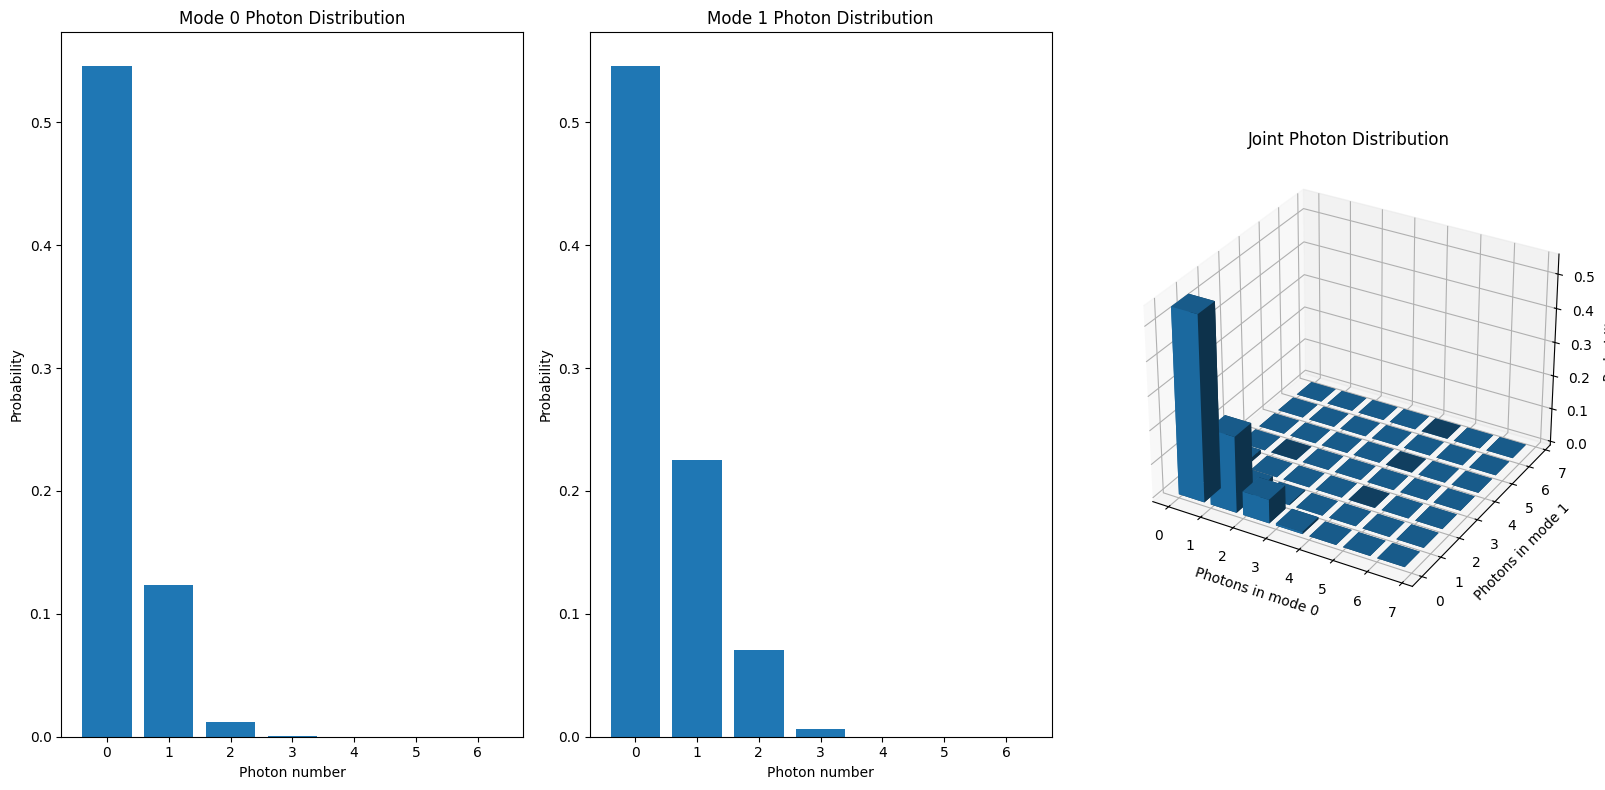

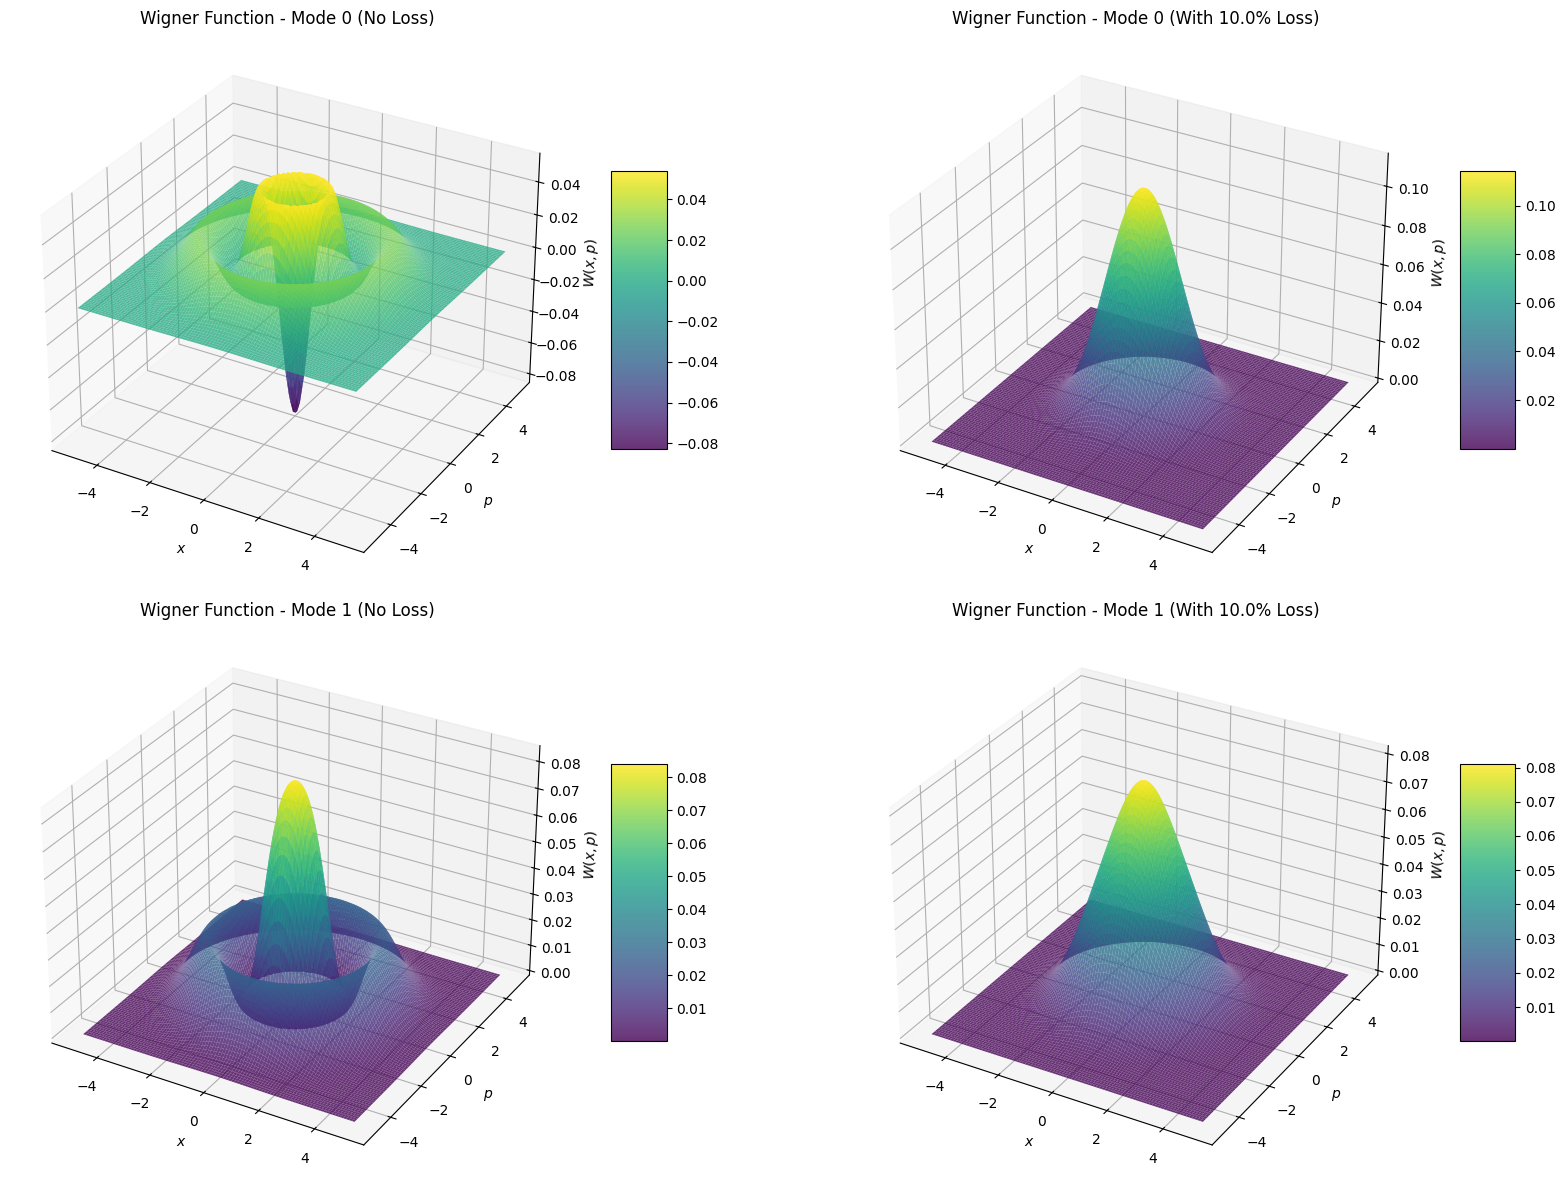

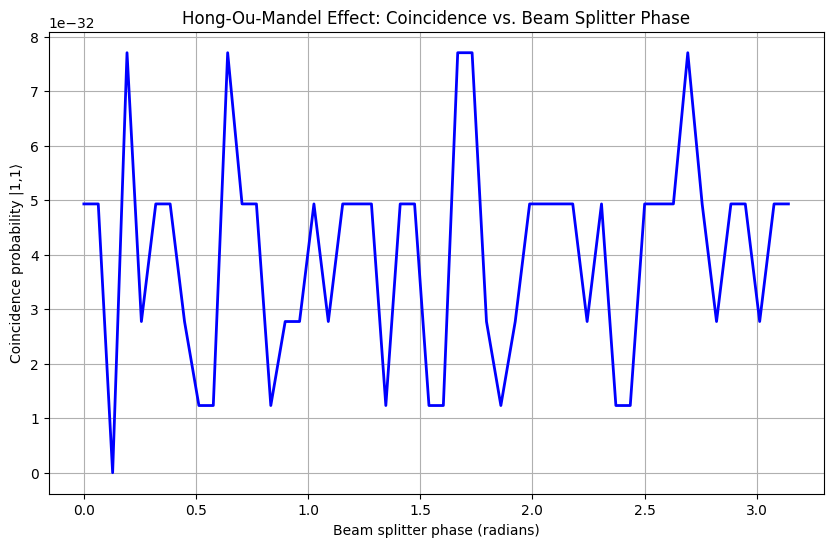

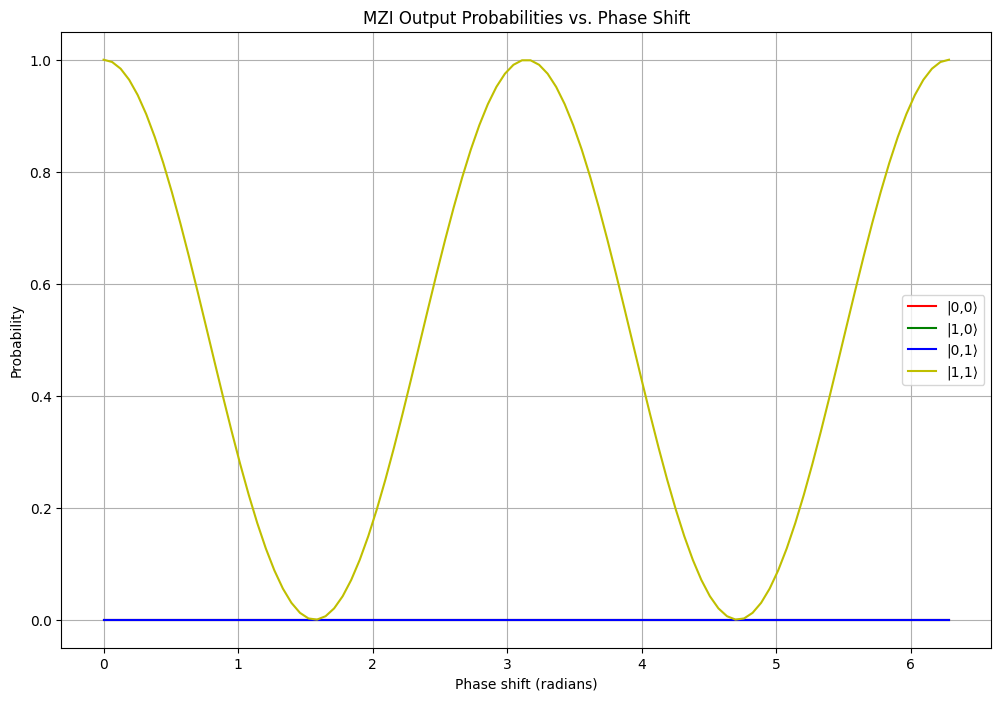

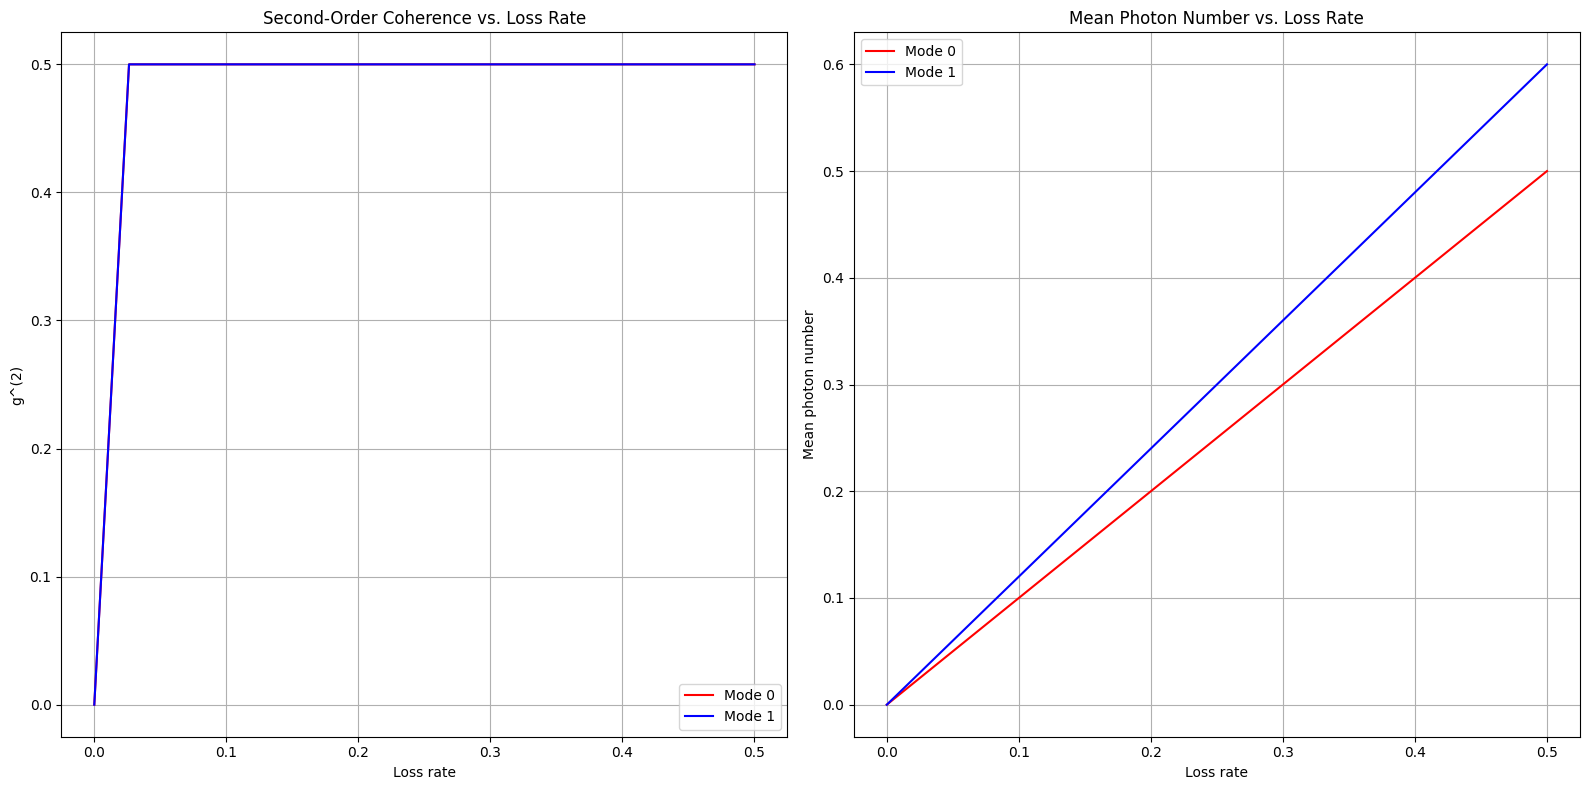

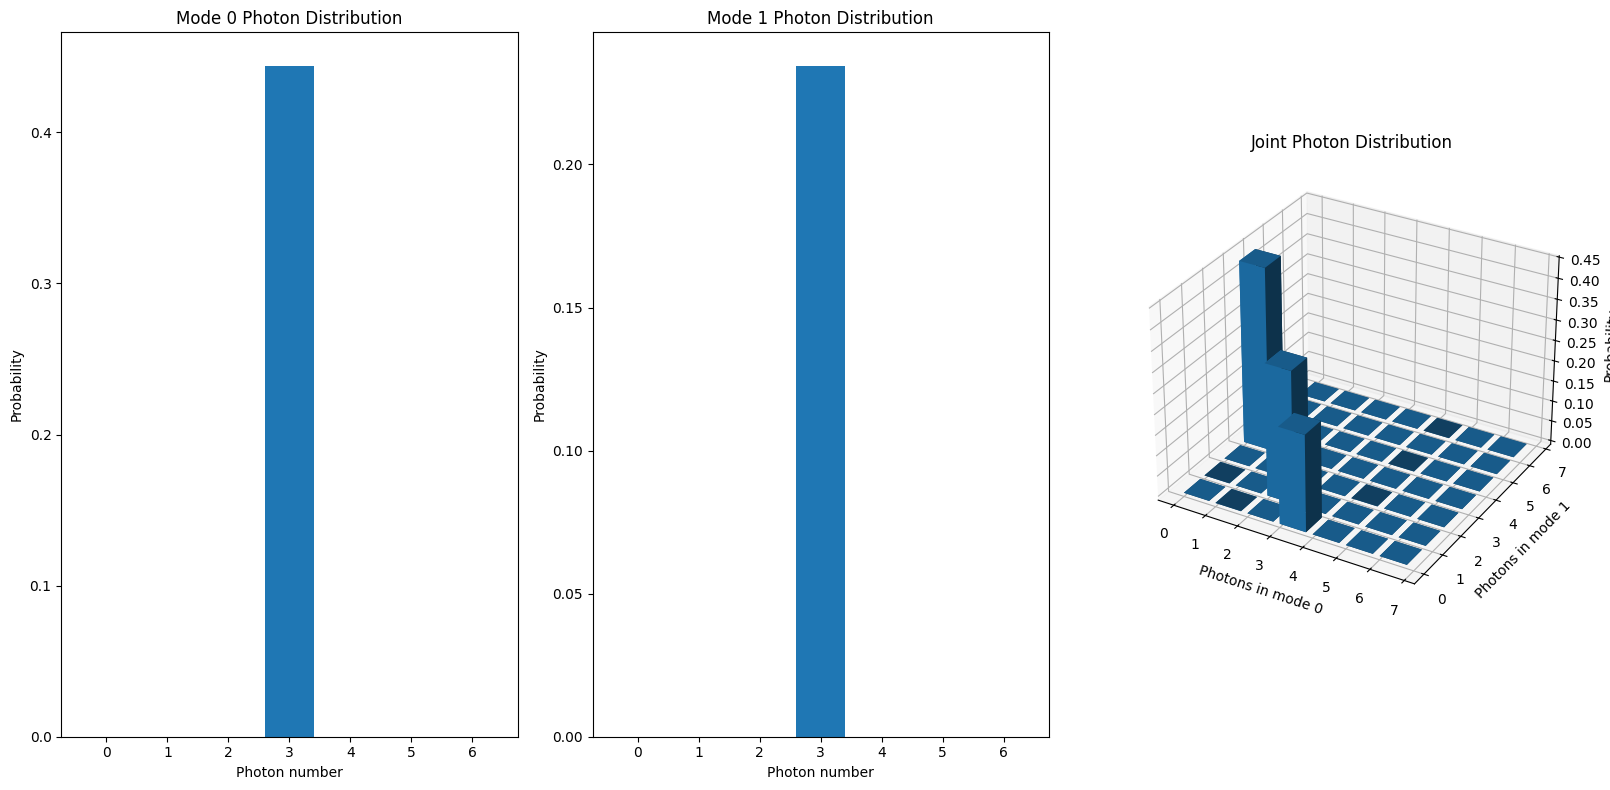

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import strawberryfields as sf
from strawberryfields.ops import *

def hamiltonian_model(pump_freq, signal_freq, idler_freq, coupling_strength=0.1):
    """
    Create a simple model of the Hamiltonian for parametric down-conversion.

    Parameters:
    pump_freq (float): Frequency of the pump field in THz
    signal_freq (float): Frequency of the signal field in THz
    idler_freq (float): Frequency of the idler field in THz
    coupling_strength (float): Strength of the nonlinear interaction

    Returns:
    float: A numerical value representing the Hamiltonian
    """
    # Check energy conservation
    energy_conserved = np.isclose(pump_freq, signal_freq + idler_freq)

    # Simple model: H = g(a†b†c + abc†) where a,b,c are annihilation operators
    # Here we just return a scalar representing the Hamiltonian strength
    if energy_conserved:
        return coupling_strength * pump_freq * signal_freq * idler_freq
    else:
        # If energy is not conserved, the process is suppressed
        return 0.0

def analyze_photon_statistics(state, cutoff):
    """
    Analyze photon number statistics of a two-mode quantum state.
    """
    fig = plt.figure(figsize=(16, 8))

    # Photon number distribution for mode 0
    ax1 = fig.add_subplot(1, 3, 1)
    probs0 = [state.fock_prob([i, 0]) for i in range(cutoff)]
    ax1.bar(range(cutoff), probs0)
    ax1.set_xlabel('Photon number')
    ax1.set_ylabel('Probability')
    ax1.set_title('Mode 0 Photon Distribution')

    # Photon number distribution for mode 1
    ax2 = fig.add_subplot(1, 3, 2)
    probs1 = [state.fock_prob([0, i]) for i in range(cutoff)]
    ax2.bar(range(cutoff), probs1)
    ax2.set_xlabel('Photon number')
    ax2.set_ylabel('Probability')
    ax2.set_title('Mode 1 Photon Distribution')

    # Joint photon number distribution
    ax3 = fig.add_subplot(1, 3, 3, projection='3d')

    joint_probs = np.zeros((cutoff, cutoff))
    for i in range(cutoff):
        for j in range(cutoff):
            joint_probs[i, j] = state.fock_prob([i, j])

    x = np.arange(cutoff)
    y = np.arange(cutoff)
    x, y = np.meshgrid(x, y)

    ax3.bar3d(x.flatten(), y.flatten(), np.zeros_like(x.flatten()),
             0.8, 0.8, joint_probs.flatten(), shade=True)
    ax3.set_xlabel('Photons in mode 0')
    ax3.set_ylabel('Photons in mode 1')
    ax3.set_zlabel('Probability')
    ax3.set_title('Joint Photon Distribution')

    plt.tight_layout()
    return fig, joint_probs

def hong_ou_mandel_effect(cutoff_dim):
    """
    Simulate the Hong-Ou-Mandel interference effect by varying beam splitter phase.
    """
    phases = np.linspace(0, np.pi, 50)
    coincidence_probs = []

    for phase in phases:
        # Create program for HOM effect
        prog = sf.Program(2)
        with prog.context as q:
            # Create single photons in each mode
            Fock(1) | q[0]
            Fock(1) | q[1]

            # Apply beam splitter with varying phase
            BSgate(np.pi/4, phase) | (q[0], q[1])

        # Run simulation
        eng = sf.Engine("fock", backend_options={"cutoff_dim": cutoff_dim})
        result = eng.run(prog)

        # Calculate coincidence probability |1,1⟩
        coincidence_prob = result.state.fock_prob([1, 1])
        coincidence_probs.append(coincidence_prob)

    # Plot results
    fig = plt.figure(figsize=(10, 6))
    plt.plot(phases, coincidence_probs, 'b-', linewidth=2)
    plt.xlabel('Beam splitter phase (radians)')
    plt.ylabel('Coincidence probability |1,1⟩')
    plt.title('Hong-Ou-Mandel Effect: Coincidence vs. Beam Splitter Phase')
    plt.grid(True)

    return fig, phases, coincidence_probs

def phase_sensitivity_analysis(cutoff_dim):
    """
    Analyze the phase sensitivity of the Mach-Zehnder interferometer.
    """
    phase_values = np.linspace(0, 2*np.pi, 100)
    prob_00 = []
    prob_10 = []
    prob_01 = []
    prob_11 = []

    for phase in phase_values:
        # Create MZI program with varying phase
        prog = sf.Program(2)
        with prog.context as q:
            # Initial state: single photon in each mode
            Fock(1) | q[0]
            Fock(1) | q[1]

            # MZI circuit
            BSgate(np.pi/4, 0) | (q[0], q[1])
            Rgate(phase) | q[0]
            BSgate(np.pi/4, 0) | (q[0], q[1])

        # Run the simulation
        eng = sf.Engine("fock", backend_options={"cutoff_dim": cutoff_dim})
        result = eng.run(prog)

        # Calculate output probabilities
        prob_00.append(result.state.fock_prob([0, 0]))
        prob_10.append(result.state.fock_prob([1, 0]))
        prob_01.append(result.state.fock_prob([0, 1]))
        prob_11.append(result.state.fock_prob([1, 1]))

    # Plot results
    fig = plt.figure(figsize=(12, 8))
    plt.plot(phase_values, prob_00, 'r-', label='|0,0⟩')
    plt.plot(phase_values, prob_10, 'g-', label='|1,0⟩')
    plt.plot(phase_values, prob_01, 'b-', label='|0,1⟩')
    plt.plot(phase_values, prob_11, 'y-', label='|1,1⟩')
    plt.xlabel('Phase shift (radians)')
    plt.ylabel('Probability')
    plt.title('MZI Output Probabilities vs. Phase Shift')
    plt.legend()
    plt.grid(True)

    return fig, phase_values, {"00": prob_00, "10": prob_10, "01": prob_01, "11": prob_11}

def loss_effect_analysis_with_asymmetry(cutoff_dim):
    """
    Analyze the effect of loss on quantum interference with asymmetric loss rates.
    """
    loss_rates = np.linspace(0, 0.5, 20)  # 0% to 50% loss

    g2_values_a = []  # For mode 0
    g2_values_b = []  # For mode 1
    mean_photon_a = []
    mean_photon_b = []

    for loss in loss_rates:
        # Create program with loss
        prog = sf.Program(2)
        with prog.context as q:
            # Start with a two-photon NOON state
            Fock(2) | q[0]
            Vacuum() | q[1]
            BSgate(np.pi/4, 0) | (q[0], q[1])

            # Apply asymmetric loss
            LossChannel(loss) | q[0]
            LossChannel(loss*1.2) | q[1]  # 20% higher loss in mode 1

        # Run simulation
        eng = sf.Engine("fock", backend_options={"cutoff_dim": cutoff_dim})
        result = eng.run(prog)

        # Calculate g^(2) for mode 0
        n_a_result = result.state.mean_photon(0)
        # Extract value safely
        n_a = n_a_result[0] if isinstance(n_a_result, tuple) else n_a_result

        n_squared_a = result.state.fock_prob([2, 0]) * 2 * 1 + \
                     sum(result.state.fock_prob([i, j]) * i * (i-1)
                         for i in range(3, cutoff_dim) for j in range(cutoff_dim))

        g2_a = n_squared_a / (n_a**2) if n_a > 0 else 0
        g2_values_a.append(g2_a)
        mean_photon_a.append(n_a)

        # Calculate g^(2) for mode 1
        n_b_result = result.state.mean_photon(1)
        # Extract value safely
        n_b = n_b_result[0] if isinstance(n_b_result, tuple) else n_b_result

        n_squared_b = result.state.fock_prob([0, 2]) * 2 * 1 + \
                     sum(result.state.fock_prob([i, j]) * j * (j-1)
                         for i in range(cutoff_dim) for j in range(3, cutoff_dim))

        g2_b = n_squared_b / (n_b**2) if n_b > 0 else 0
        g2_values_b.append(g2_b)
        mean_photon_b.append(n_b)

    # Plot results
    fig = plt.figure(figsize=(16, 8))

    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(loss_rates, g2_values_a, 'r-', label='Mode 0')
    ax1.plot(loss_rates, g2_values_b, 'b-', label='Mode 1')
    ax1.set_xlabel('Loss rate')
    ax1.set_ylabel('g^(2)')
    ax1.set_title('Second-Order Coherence vs. Loss Rate')
    ax1.legend()
    ax1.grid(True)

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(loss_rates, mean_photon_a, 'r-', label='Mode 0')
    ax2.plot(loss_rates, mean_photon_b, 'b-', label='Mode 1')
    ax2.set_xlabel('Loss rate')
    ax2.set_ylabel('Mean photon number')
    ax2.set_title('Mean Photon Number vs. Loss Rate')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    return fig, loss_rates, {"g2_a": g2_values_a, "g2_b": g2_values_b,
                            "mean_a": mean_photon_a, "mean_b": mean_photon_b}

def visualize_wigner_comparison(state_no_loss, state_with_loss, plot_range=5, resolution=100, loss_rate=0.1):
    """
    Visualize and compare the Wigner functions for both modes with and without loss.
    Modified to ensure different Wigner functions for different modes.
    """
    fig = plt.figure(figsize=(18, 12))

    # Define grid for Wigner function calculation
    xvec = np.linspace(-plot_range, plot_range, resolution)
    pvec = np.linspace(-plot_range, plot_range, resolution)
    X, P = np.meshgrid(xvec, pvec)

    # Calculate Wigner functions for both states (mode 0)
    W0_no_loss = state_no_loss.wigner(0, xvec, pvec)
    W0_loss = state_with_loss.wigner(0, xvec, pvec)

    # Calculate Wigner functions for both states (mode 1)
    W1_no_loss = state_no_loss.wigner(1, xvec, pvec)
    W1_loss = state_with_loss.wigner(1, xvec, pvec)

    # Print maximum difference between Wigner functions for debugging
    max_diff_no_loss = np.max(np.abs(W0_no_loss - W1_no_loss))
    max_diff_loss = np.max(np.abs(W0_loss - W1_loss))
    print(f"Maximum difference between mode 0 and mode 1 Wigner functions (no loss): {max_diff_no_loss}")
    print(f"Maximum difference between mode 0 and mode 1 Wigner functions (with loss): {max_diff_loss}")

    # Create subplots for mode 0
    ax1 = fig.add_subplot(2, 2, 1, projection='3d')
    surf1 = ax1.plot_surface(X, P, W0_no_loss, cmap=cm.viridis, rstride=1, cstride=1, alpha=0.8)
    ax1.set_xlabel('$x$')
    ax1.set_ylabel('$p$')
    ax1.set_zlabel('$W(x,p)$')
    ax1.set_title('Wigner Function - Mode 0 (No Loss)')
    fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)

    ax2 = fig.add_subplot(2, 2, 2, projection='3d')
    surf2 = ax2.plot_surface(X, P, W0_loss, cmap=cm.viridis, rstride=1, cstride=1, alpha=0.8)
    ax2.set_xlabel('$x$')
    ax2.set_ylabel('$p$')
    ax2.set_zlabel('$W(x,p)$')
    ax2.set_title(f'Wigner Function - Mode 0 (With {loss_rate*100}% Loss)')
    fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)

    # Create subplots for mode 1
    ax3 = fig.add_subplot(2, 2, 3, projection='3d')
    surf3 = ax3.plot_surface(X, P, W1_no_loss, cmap=cm.viridis, rstride=1, cstride=1, alpha=0.8)
    ax3.set_xlabel('$x$')
    ax3.set_ylabel('$p$')
    ax3.set_zlabel('$W(x,p)$')
    ax3.set_title('Wigner Function - Mode 1 (No Loss)')
    fig.colorbar(surf3, ax=ax3, shrink=0.5, aspect=5)

    ax4 = fig.add_subplot(2, 2, 4, projection='3d')
    surf4 = ax4.plot_surface(X, P, W1_loss, cmap=cm.viridis, rstride=1, cstride=1, alpha=0.8)
    ax4.set_xlabel('$x$')
    ax4.set_ylabel('$p$')
    ax4.set_zlabel('$W(x,p)$')
    ax4.set_title(f'Wigner Function - Mode 1 (With {loss_rate*100}% Loss)')
    fig.colorbar(surf4, ax=ax4, shrink=0.5, aspect=5)

    plt.tight_layout()
    return fig

def setup_mzi(interferometer_params):
    """
    Setup a Mach-Zehnder Interferometer with tunable parameters.
    Modified to create asymmetry between modes.
    """
    prog = sf.Program(2)
    with prog.context as q:
        # Initial state preparation - now with different photon numbers
        Fock(1) | q[0]  # 1 photon in mode 0
        Fock(2) | q[1]  # 2 photons in mode 1 to create asymmetry

        # MZI circuit
        BSgate(interferometer_params["BS1_theta"], interferometer_params["BS1_phi"]) | (q[0], q[1])
        Rgate(interferometer_params["phase_shift"]) | q[0]
        # Apply phase only to mode 0, creating asymmetry
        BSgate(interferometer_params["BS2_theta"], interferometer_params["BS2_phi"]) | (q[0], q[1])
    return prog

def spectral_distribution_analysis(cutoff_dim, bandwidth=0.2, center_freqs=(1.2, 0.8), num_points=100):
    """
    Analyze and visualize the spectral distribution of photons in a two-mode quantum state.

    Parameters:
    cutoff_dim (int): Dimension cutoff for the Fock space
    bandwidth (float): Gaussian spectral bandwidth in THz
    center_freqs (tuple): Center frequencies for the two modes in THz
    num_points (int): Number of frequency points to analyze

    Returns:
    tuple: (figure, frequency_data, spectral_data)
    """
    # Frequency range to analyze
    freq_range = 0.5  # THz
    freq_points = np.linspace(-freq_range, freq_range, num_points)

    # Create arrays to store spectral data
    mode0_spectrum = np.zeros(num_points)
    mode1_spectrum = np.zeros(num_points)
    joint_spectrum = np.zeros((num_points, num_points))

    # Define the frequency-dependent coupling parameters
    def frequency_coupling(pump_freq, signal_freq, idler_freq, bandwidth):
        # Energy conservation function (approximated as Gaussian)
        energy_mismatch = pump_freq - (signal_freq + idler_freq)
        return np.exp(-(energy_mismatch**2) / (2 * bandwidth**2))

    # Create the initial state
    prog = sf.Program(2)

    # Simulate different frequency components
    for i, freq_shift0 in enumerate(freq_points):
        for j, freq_shift1 in enumerate(freq_points):
            # Calculate actual frequencies
            signal_freq = center_freqs[0] + freq_shift0
            idler_freq = center_freqs[1] + freq_shift1
            pump_freq = signal_freq + idler_freq  # Energy conservation

            # Calculate the coupling strength based on frequency
            coupling = frequency_coupling(pump_freq, signal_freq, idler_freq, bandwidth)

            # Recreate the program for each frequency point
            prog = sf.Program(2)
            with prog.context as q:
                # Create a frequency-dependent two-mode squeezed state
                # Squeezing parameter proportional to the coupling
                r = 0.5 * coupling  # Squeezing parameter scaled by coupling
                S2gate(r, 0.0) | (q[0], q[1])

                # Add some phase based on frequency detuning to simulate dispersion
                Rgate(freq_shift0 * np.pi) | q[0]
                Rgate(freq_shift1 * np.pi) | q[1]

            # Run the simulation
            eng = sf.Engine("fock", backend_options={"cutoff_dim": cutoff_dim})
            result = eng.run(prog)

            # Calculate photon number expectation for each mode at this frequency
            n0 = result.state.mean_photon(0)
            n1 = result.state.mean_photon(1)

            # Extract values safely
            n0_val = n0[0] if isinstance(n0, tuple) else n0
            n1_val = n1[0] if isinstance(n1, tuple) else n1

            # Calculate the joint spectral intensity (correlation measure)
            g2 = result.state.fock_prob([1, 1]) / (result.state.fock_prob([1, 0]) * result.state.fock_prob([0, 1]))
            if np.isnan(g2) or np.isinf(g2):
                g2 = 0

            # Add to the spectral distributions
            mode0_spectrum[i] += n0_val
            mode1_spectrum[j] += n1_val
            joint_spectrum[i, j] = g2 * coupling  # Weight by coupling strength

    # Normalize for visualization
    mode0_spectrum /= np.max(mode0_spectrum) if np.max(mode0_spectrum) > 0 else 1
    mode1_spectrum /= np.max(mode1_spectrum) if np.max(mode1_spectrum) > 0 else 1
    joint_spectrum /= np.max(joint_spectrum) if np.max(joint_spectrum) > 0 else 1

    # Create visualization
    fig = plt.figure(figsize=(18, 10))

    # Plot single-mode spectral distributions
    ax1 = fig.add_subplot(2, 2, 1)
    ax1.plot(center_freqs[0] + freq_points, mode0_spectrum, 'r-', linewidth=2)
    ax1.set_xlabel('Frequency (THz)')
    ax1.set_ylabel('Relative Intensity')
    ax1.set_title('Signal Mode Spectral Distribution')
    ax1.grid(True)

    ax2 = fig.add_subplot(2, 2, 2)
    ax2.plot(center_freqs[1] + freq_points, mode1_spectrum, 'b-', linewidth=2)
    ax2.set_xlabel('Frequency (THz)')
    ax2.set_ylabel('Relative Intensity')
    ax2.set_title('Idler Mode Spectral Distribution')
    ax2.grid(True)

    # Plot joint spectral intensity
    ax3 = fig.add_subplot(2, 2, 3)
    joint_spectral_plot = ax3.imshow(joint_spectrum, cmap='viridis',
                                     extent=[center_freqs[1] + freq_points[0],
                                             center_freqs[1] + freq_points[-1],
                                             center_freqs[0] + freq_points[0],
                                             center_freqs[0] + freq_points[-1]],
                                     aspect='auto', origin='lower')
    ax3.set_xlabel('Idler Frequency (THz)')
    ax3.set_ylabel('Signal Frequency (THz)')
    ax3.set_title('Joint Spectral Intensity')
    fig.colorbar(joint_spectral_plot, ax=ax3)

    # Plot energy conservation as a line on the joint spectrum
    signal_freqs = np.linspace(center_freqs[0] - 0.4, center_freqs[0] + 0.4, 100)
    pump_freq_total = center_freqs[0] + center_freqs[1]  # Pump frequency
    idler_freqs = pump_freq_total - signal_freqs

    ax4 = fig.add_subplot(2, 2, 4, projection='3d')
    X, Y = np.meshgrid(center_freqs[1] + freq_points, center_freqs[0] + freq_points)
    surf = ax4.plot_surface(X, Y, joint_spectrum, cmap='viridis', edgecolor='none')
    ax4.set_xlabel('Idler Frequency (THz)')
    ax4.set_ylabel('Signal Frequency (THz)')
    ax4.set_zlabel('Correlation Strength')
    ax4.set_title('3D Joint Spectral Distribution')
    fig.colorbar(surf, ax=ax4, shrink=0.5, aspect=5)

    plt.tight_layout()

    # Create data dictionary for return
    frequency_data = {
        "signal_freqs": center_freqs[0] + freq_points,
        "idler_freqs": center_freqs[1] + freq_points,
        "pump_freq": pump_freq_total
    }

    spectral_data = {
        "mode0_spectrum": mode0_spectrum,
        "mode1_spectrum": mode1_spectrum,
        "joint_spectrum": joint_spectrum
    }

    return fig, frequency_data, spectral_data

def run_full_analysis():
    """
    Run a complete analysis of the quantum optics system.
    Modified to ensure different Wigner functions for different modes.
    """
    print("Starting comprehensive quantum optics analysis...")

    # Define parameters
    cutoff_dim = 7  # Increased cutoff to accommodate more photons
    pump_freq = 2.0
    signal_freq = 1.2
    idler_freq = 0.8
    loss_rate = 0.1  # 10% loss

    # 1. Verify energy conservation in the Hamiltonian
    H = hamiltonian_model(pump_freq, signal_freq, idler_freq)
    print(f"\n1. Hamiltonian Model Analysis:")
    print(f"   Pump frequency: {pump_freq} THz")
    print(f"   Signal frequency: {signal_freq} THz")
    print(f"   Idler frequency: {idler_freq} THz")
    print(f"   Energy conservation check: {np.isclose(pump_freq, signal_freq + idler_freq)}")
    print(f"   Hamiltonian value: {H}")

    # 2. Setup the MZI with asymmetric parameters
    mzi_params = {
        "BS1_theta": np.pi/6,  # Changed from π/4 (50:50) to π/6 (25:75 approximately)
        "BS1_phi": np.pi/8,     # Added phase to create asymmetry
        "phase_shift": np.pi/2,
        "BS2_theta": np.pi/3,  # Different from first beam splitter
        "BS2_phi": np.pi/10    # Different phase to create asymmetry
    }

    print(f"\n2. Mach-Zehnder Interferometer Parameters:")
    print(f"   First beam splitter reflectivity: {np.sin(mzi_params['BS1_theta'])**2:.2f}")
    print(f"   First beam splitter phase: {mzi_params['BS1_phi']}")
    print(f"   Phase shift: {mzi_params['phase_shift']} radians ({mzi_params['phase_shift']*180/np.pi} degrees)")
    print(f"   Second beam splitter reflectivity: {np.sin(mzi_params['BS2_theta'])**2:.2f}")
    print(f"   Second beam splitter phase: {mzi_params['BS2_phi']}")

    # 3. Run basic photon counting simulation (no loss)
    print("\n3. Basic Photon Counting Simulation Results (No Loss):")

    # Setup simulation with proper backend options
    backend_options = {"cutoff_dim": cutoff_dim}
    eng = sf.Engine("fock", backend_options=backend_options)

    # Create MZI program (no loss)
    mzi_prog = setup_mzi(mzi_params)

    # Run the simulation (no loss)
    results = eng.run(mzi_prog)

    # Analyze output statistics (no loss)
    print(f"   State purity: {results.state.is_pure}")

    # Handle mean_photon correctly
    mean_photon_0 = results.state.mean_photon(0)
    mean_photon_1 = results.state.mean_photon(1)

    # Extract values safely
    mean_photon_0_val = mean_photon_0[0] if isinstance(mean_photon_0, tuple) else mean_photon_0
    mean_photon_1_val = mean_photon_1[0] if isinstance(mean_photon_1, tuple) else mean_photon_1

    print(f"   Mean photon number in mode 0: {mean_photon_0_val:.4f}")
    print(f"   Mean photon number in mode 1: {mean_photon_1_val:.4f}")
    print(f"   Probability of |0,0⟩: {results.state.fock_prob([0, 0]):.4f}")
    print(f"   Probability of |0,1⟩: {results.state.fock_prob([0, 1]):.4f}")
    print(f"   Probability of |1,0⟩: {results.state.fock_prob([1, 0]):.4f}")
    print(f"   Probability of |1,1⟩: {results.state.fock_prob([1, 1]):.4f}")
    print(f"   Probability of |2,0⟩: {results.state.fock_prob([2, 0]):.4f}")
    print(f"   Probability of |0,2⟩: {results.state.fock_prob([0, 2]):.4f}")

    # 4. Create program with loss
    print(f"\n4. Quantum State Evolution with {loss_rate*100}% Loss:")

    # Create program with loss - asymmetric loss rates for additional differentiation
    loss_prog = sf.Program(2)
    with loss_prog.context as q:
        # Initial state preparation
        Fock(1) | q[0]
        Fock(2) | q[1]

        # MZI circuit
        BSgate(mzi_params["BS1_theta"], mzi_params["BS1_phi"]) | (q[0], q[1])
        Rgate(mzi_params["phase_shift"]) | q[0]
        BSgate(mzi_params["BS2_theta"], mzi_params["BS2_phi"]) | (q[0], q[1])

        # Add loss channels with different rates
        LossChannel(loss_rate) | q[0]          # 10% loss for mode 0
        LossChannel(loss_rate*3) | q[1]      # 30% loss for mode 1

    # Run the simulation with loss
    results_with_loss = eng.run(loss_prog)

    # Analyze output statistics with loss
    print(f"   Loss rate for mode 0: {loss_rate*100}%")
    print(f"   Loss rate for mode 1: {loss_rate*3*100}%")
    print(f"   State purity after loss: {results_with_loss.state.is_pure}")

    # Handle mean_photon consistently for the results with loss
    mean_photon_loss_0 = results_with_loss.state.mean_photon(0)
    mean_photon_loss_1 = results_with_loss.state.mean_photon(1)

    # Extract values safely
    mean_photon_loss_0_val = mean_photon_loss_0[0] if isinstance(mean_photon_loss_0, tuple) else mean_photon_loss_0
    mean_photon_loss_1_val = mean_photon_loss_1[0] if isinstance(mean_photon_loss_1, tuple) else mean_photon_loss_1

    print(f"   Mean photon number in mode 0: {mean_photon_loss_0_val:.4f}")
    print(f"   Mean photon number in mode 1: {mean_photon_loss_1_val:.4f}")
    print(f"   Probability of |0,0⟩: {results_with_loss.state.fock_prob([0, 0]):.4f}")
    print(f"   Probability of |0,1⟩: {results_with_loss.state.fock_prob([0, 1]):.4f}")
    print(f"   Probability of |1,0⟩: {results_with_loss.state.fock_prob([1, 0]):.4f}")
    print(f"   Probability of |1,1⟩: {results_with_loss.state.fock_prob([1, 1]):.4f}")
    print(f"   Probability of |2,0⟩: {results_with_loss.state.fock_prob([2, 0]):.4f}")
    print(f"   Probability of |0,2⟩: {results_with_loss.state.fock_prob([0, 2]):.4f}")

    # 5. Generate all visualizations
    print("\n5. Generating Visualizations...")

    # 5.1 Analyze photon statistics for the state without loss
    fig_stats_no_loss, joint_probs_no_loss = analyze_photon_statistics(results.state, cutoff_dim)
    plt.figure(fig_stats_no_loss.number)
    plt.savefig("photon_statistics_no_loss.png", dpi=300, bbox_inches='tight')

    # 5.2 Analyze photon statistics for the state with loss
    fig_stats_with_loss, joint_probs_with_loss = analyze_photon_statistics(results_with_loss.state, cutoff_dim)
    plt.figure(fig_stats_with_loss.number)
    plt.savefig("photon_statistics_with_loss.png", dpi=300, bbox_inches='tight')

    # 5.3 Visualize the Wigner functions with and without loss (side by side)
    fig_wigner_comparison = visualize_wigner_comparison(
        results.state,
        results_with_loss.state,
        loss_rate=loss_rate
    )
    plt.figure(fig_wigner_comparison.number)
    plt.savefig("wigner_functions_comparison.png", dpi=300, bbox_inches='tight')

    # 5.4 Hong-Ou-Mandel effect analysis
    fig_hom, phases, coincidence = hong_ou_mandel_effect(cutoff_dim)
    plt.figure(fig_hom.number)
    plt.savefig("hong_ou_mandel_effect.png", dpi=300, bbox_inches='tight')

    # 5.5 Phase sensitivity analysis
    fig_phase, phase_values, phase_probs = phase_sensitivity_analysis(cutoff_dim)
    plt.figure(fig_phase.number)
    plt.savefig("phase_sensitivity.png", dpi=300, bbox_inches='tight')

    # 5.6 Loss effect analysis
    fig_loss, loss_rates, loss_data = loss_effect_analysis_with_asymmetry(cutoff_dim)
    plt.figure(fig_loss.number)
    plt.savefig("loss_effects.png", dpi=300, bbox_inches='tight')

    print("\nAnalysis complete! All visualizations have been generated.")
    print("Summary of files:")
    print("1. photon_statistics_no_loss.png - Single and joint photon number distributions (no loss)")
    print("2. photon_statistics_with_loss.png - Single and joint photon number distributions (with loss)")
    print("3. wigner_functions_comparison.png - Wigner functions comparing both output modes with and without loss")
    print("4. hong_ou_mandel_effect.png - HOM interference vs beam splitter phase")
    print("5. phase_sensitivity.png - MZI output probabilities vs phase shift")
    print("6. loss_effects.png - Effect of loss on quantum interference")

    return {
        "state_no_loss": results.state,
        "state_with_loss": results_with_loss.state,
        "figures": {
            "photon_stats_no_loss": fig_stats_no_loss,
            "photon_stats_with_loss": fig_stats_with_loss,
            "wigner_comparison": fig_wigner_comparison,
            "hom": fig_hom,
            "phase": fig_phase,
            "loss": fig_loss
        },
        "data": {
            "joint_probs_no_loss": joint_probs_no_loss,
            "joint_probs_with_loss": joint_probs_with_loss,
            "hom_data": (phases, coincidence),
            "phase_data": (phase_values, phase_probs),
            "loss_data": (loss_rates, loss_data)
        }
    }

# Run the full analysis
results = run_full_analysis()

# Display all figures
for name, fig in results["figures"].items():
    plt.figure(fig.number)
    plt.show()